# Assignment 2: 2018 Kaggle Survey Challenge: Sallary Prediction

[Kaggle Survey Challenge Page](https://www.kaggle.com/kaggle/kaggle-survey-2018/home)  
[missingno github page](https://github.com/ResidentMario/missingno)

Start by importing libraries

In [1]:
#!pip install missingno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from IPython.display import display, HTML
from IPython.display import clear_output
import warnings
import seaborn as sns
import sklearn

try:
    import missingno as msno
except:
    !pip install missingno

try:
    from category_encoders import *
except:
    !pip install category_encoders

from IPython.display import clear_output
import textwrap

warnings.simplefilter('ignore')

import sys
print (sys.version)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


Download a script that performs cell skipping for cells that takes a very long time to execute, such as grid search.

In [2]:
marking = True

try:
    %load_ext skip_kernel_extension
except:
    !wget https://raw.githubusercontent.com/rhklite/notebook_magic/master/skip_kernel_extension.py
    %load_ext skip_kernel_extension

## Step 1: Data Cleaning

### Section Summary

**Handling Missing Values**  
- Through previous iterations of data cleaning, it was found that **Question 17,20,22,43,and 37** are questions that asked the respondant to pick a "most _blank_" from the previous question. For these questions, there is a large number of missing NA if the respondant only picked one option in the previous question.
For instance, For the respondants who picked 2 options in question 16, there were 5 missing responses in question 17, and for the respondants only picked 1 option in question 16, there were around 2500 missing responses in question 17.
For these cases, the missing value is filled with that single entry from the previous question, as that single entry was indeed the "most _blank_" option for the repondant.
Reason that these question are missing entries might be due to how the repondants were prompted to answer each questions, or people who only picked one option are not inclined to answer that the follow up question.

- Furthermore, **Q27-30** also saw a big drop in response rate. These are questions that asks about which products that the repondants use. These are skipped likely because there is a student population answering this survey, which whom does not use any products.

- Lastly, it is shown that there are increasing number of missing values as people progress in the survey. This is likely due to people's patience on answering the survey wears out as they continue. This likely means that the survey is too lenghty, thus people are leaving before finishing it.

- Questions with over 15% of its data missing are dropped, then missing data entries in the remaining questions are dropped.

**Encoding Strategy**  
<a href="#1.3">See section 1.3 Encoding Strategy</a> for explanation on encoding strategy and rationale.

### 1.1 Filtering Out the Missing Values

In [3]:
df=pd.read_csv("Kaggle_Salary.csv", low_memory=False, index_col=0)

In [4]:
df.shape

(15430, 396)

In [5]:
# setting the question row to be -1 index for easy index mapping
df.iloc[0, df.columns.get_loc('index')] = -1

This prints out all the columns so we can decide how to clean up the data based on what kind of questions are asked.

In [6]:
pd.set_option('display.max_colwidth', -1)
tmp=df.iloc[0]
tmp

Time from Start to Finish (seconds)    Duration (in seconds)                                                                                                                                                                                                                    
Q1                                     What is your gender? - Selected Choice                                                                                                                                                                                                   
Q1_OTHER_TEXT                          What is your gender? - Prefer to self-describe - Text                                                                                                                                                                                    
Q2                                     What is your age (# years)?                                                                                                                   

Removing the text column answers, because the text answers in the CSV file are just numbers, instead of having actual text. 

In [7]:
tmp_col=[]
for col in df.columns: 
    if (col[-4:]=='TEXT') or (col[-5:]=='OTHER'): 
        tmp_col.append(col)
df=df.drop(columns=tmp_col)
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,index
0,Duration (in seconds),What is your gender? - Selected Choice,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Which best describes your undergraduate major? - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice,How many years of experience do you have in your current role?,What is your current yearly compensation (approximate $USD)?,...,What tools and methods do you use to make your work easy to reproduce? (Select all that apply) - Selected Choice - Other,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Too expensive,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Too time-consuming,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Requires too much technical knowledge,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Afraid that others will use my work without giving proper credit,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Not enough incentives to share my work,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - I had never considered making my work easier for others to reproduce,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - None of these reasons apply to me,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Other,-1.0
2,434,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,18668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,718,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,2726,...,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,731,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,682,...,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,2.0
7,959,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system administration",Other,Academics/Education,10-15,11957,...,NaN,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier for others to reproduce,NaN,NaN,3.0


The code below groups all the columns that belongs to one questions together, then check if all the columns have NA. If so, then that data entry is known to be missing an answer for that particular question. Following this, a temp dataframe is made, with 2 columns added for each question (1) is this question skipped, (2) how many entries were picked. These are used to help determine which row of missing value can be filled.

In [8]:
quest_list=df.columns.values.tolist()
i=1
Q_lost=50

for x in range (1,51): #checking all 50 questions
    q_key= 'Q'+str(x)
    tmp_col=[]
    #comparing the list of columns and number of questions. 
    #using while loop here avoids redundant looping through
    while q_key in quest_list[i]:
        tmp_col.append(quest_list[i])
        i+=1

    df_tmp=df[tmp_col]
    
    cols_to_check=df_tmp.columns
    col_name_na='is_na_'+str(x)
    df_tmp[col_name_na] = df_tmp.isnull().apply(lambda x: all(x), axis=1)
    col_name_entry='Q'+str(x)+'_entry_counts' 
    df_tmp[col_name_entry]=df_tmp.apply(lambda x: x.count()-1, axis=1)
    df_tmp['index']=df['index']

    if (len(df_tmp[df_tmp[col_name_na] == True])/len(df) <0.99):
        Q_lost-=1
        try:
            salary_tmp=salary_tmp.join(df_tmp.set_index('index'))
        except:
            salary_tmp = df_tmp
            salary_tmp=salary_tmp.set_index('index')

print('Finish adding columns')

Finish adding columns


In [9]:
q_fill=[17,20,22,32,37] #
for x in q_fill:
    q_key1='Q'+str(x-1)+'_entry_counts'
    q_key2='is_na_'+str(x)
    q_key3='Q'+str(x)
    q_key4='Q'+str(x-1)
    q_key5='Q'+str(x-1)+'_Part_1'
    mask = (salary_tmp[q_key1]==1) & (salary_tmp[q_key2]==True)
    
    i=quest_list.index(q_key5)
    tmp_col=[]
    while q_key4 in quest_list[i]:
        tmp_col.append(quest_list[i])
        i+=1
    
    for col in tmp_col:
        salary_tmp[q_key3]=salary_tmp[q_key3].mask(mask,salary_tmp[q_key3].fillna(salary_tmp[col]))

In [10]:
salary_tmp=salary_tmp.reset_index(level=['index'])

The following groups the columns into their respective question, then looks at how many data entries have skipped a question, for multiple choice type questions, how many choices were selected, and lastly removing the columns that have over 15% missing data.

Because data entries that skipped a question would be dropped (see section below), choosing the percentage threashold for dropping a question becomes a trade off between number of features kept vs. number of data points. As this threashold gets smaller, the number of features reduces and number of data points increases. However, this does not mean that there will be too many features removed, because of the engineered feature of *number of choices selected* for each question.

Other percentages, 20% and 30%, were also tried. It was found that threshold at 15% gives slightly better model prediction performance.

In [11]:
i=1
salary_nanplot= pd.DataFrame(columns=['Q','num_of_nan'])
salary_nandf=df[['index','Q1']]
Q_lost=50

for x in range (1,51): #checking all 50 questions
    q_key= 'Q'+str(x)
    tmp_col=[]
    #comparing the list of columns and number of questions. 
    #using while loop here avoids redundant looping through
    while q_key in quest_list[i]:
        tmp_col.append(quest_list[i])
        i+=1

    df_tmp=salary_tmp[tmp_col]
    
    cols_to_check=df_tmp.columns
    col_name_na='is_na_'+str(x)
    df_tmp[col_name_na] = df_tmp.isnull().apply(lambda x: all(x), axis=1)
    col_name_entry='Q'+str(x)+'_entry_counts' 
    df_tmp[col_name_entry]=df_tmp.apply(lambda x: x.count()-1, axis=1)
    df_tmp['index']=salary_tmp['index']
 
    salary_nandf[col_name_na]=df_tmp[col_name_na] #keeping the nan val in a df for visuals
    
    if (len(df_tmp[df_tmp[col_name_na] == True])/len(df) <0.20):
        Q_lost-=1
        try:
            salary=salary.join(df_tmp.set_index('index'))
        except:
            salary = df_tmp
            salary=salary.set_index('index')
        
    nan_len=(len(df_tmp[df_tmp[col_name_na] == True]))
    
    # recording number of missing values for each dataframe
    df_tmp2={'Q':q_key , 'num_of_nan':[nan_len]}
    nan_tmp2=pd.DataFrame(data=df_tmp2)
    salary_nanplot=pd.concat([salary_nanplot, nan_tmp2], ignore_index=True)

print('Questions dropped: ' + str(Q_lost))

Questions dropped: 21


In [12]:
salary.head()

,Q1,is_na_1,Q1_entry_counts,Q2,is_na_2,Q2_entry_counts,Q3,is_na_3,Q3_entry_counts,Q4,...,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,is_na_33,Q33_entry_counts
index,,,,,,,,,,,,,,,,,,,,,
-1.0,What is your gender? - Selected Choice,False,1,What is your age (# years)?,False,1,In which country do you currently reside?,False,1,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,...,"Where do you find public datasets? (Select all that apply) - Selected Choice - Dataset aggregator/platform (Socrata, Kaggle Public Datasets Platform, etc.)","Where do you find public datasets? (Select all that apply) - Selected Choice - I collect my own data (web-scraping, etc.)",Where do you find public datasets? (Select all that apply) - Selected Choice - Publicly released data from private companies,Where do you find public datasets? (Select all that apply) - Selected Choice - Google Search,Where do you find public datasets? (Select all that apply) - Selected Choice - Google Dataset Search,Where do you find public datasets? (Select all that apply) - Selected Choice - GitHub,Where do you find public datasets? (Select all that apply) - Selected Choice - None/I do not work with public data,Where do you find public datasets? (Select all that apply) - Selected Choice - Other,False,11
0.0,Male,False,1,30-34,False,1,Indonesia,False,1,Bachelor’s degree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
1.0,Female,False,1,30-34,False,1,United States of America,False,1,Master’s degree,...,"Dataset aggregator/platform (Socrata, Kaggle Public Datasets Platform, etc.)",NaN,NaN,NaN,NaN,GitHub,NaN,NaN,False,3
2.0,Male,False,1,22-24,False,1,India,False,1,Master’s degree,...,NaN,NaN,Publicly released data from private companies,NaN,NaN,NaN,NaN,NaN,False,1
3.0,Male,False,1,35-39,False,1,Chile,False,1,Doctoral degree,...,NaN,NaN,NaN,NaN,NaN,GitHub,NaN,NaN,False,1


### 1.2 Finding Out Correlations Between Missing Values

Three plots were used here to look at how the missing values are distributed in the dataset.

**Matrix Plot**  
The matrix plot below plots out the location of the missing data entry in 2D. This shows the location of the missing data within its own column. 

The X axis bars are each of the questions, and the Y axis bars are the number of data points, ranging from 1 to 15430.

In [13]:
salary_nandf=salary_nandf.drop(columns=['index','Q1'])
salary_nandf=salary_nandf.where(salary_nandf==False, None)

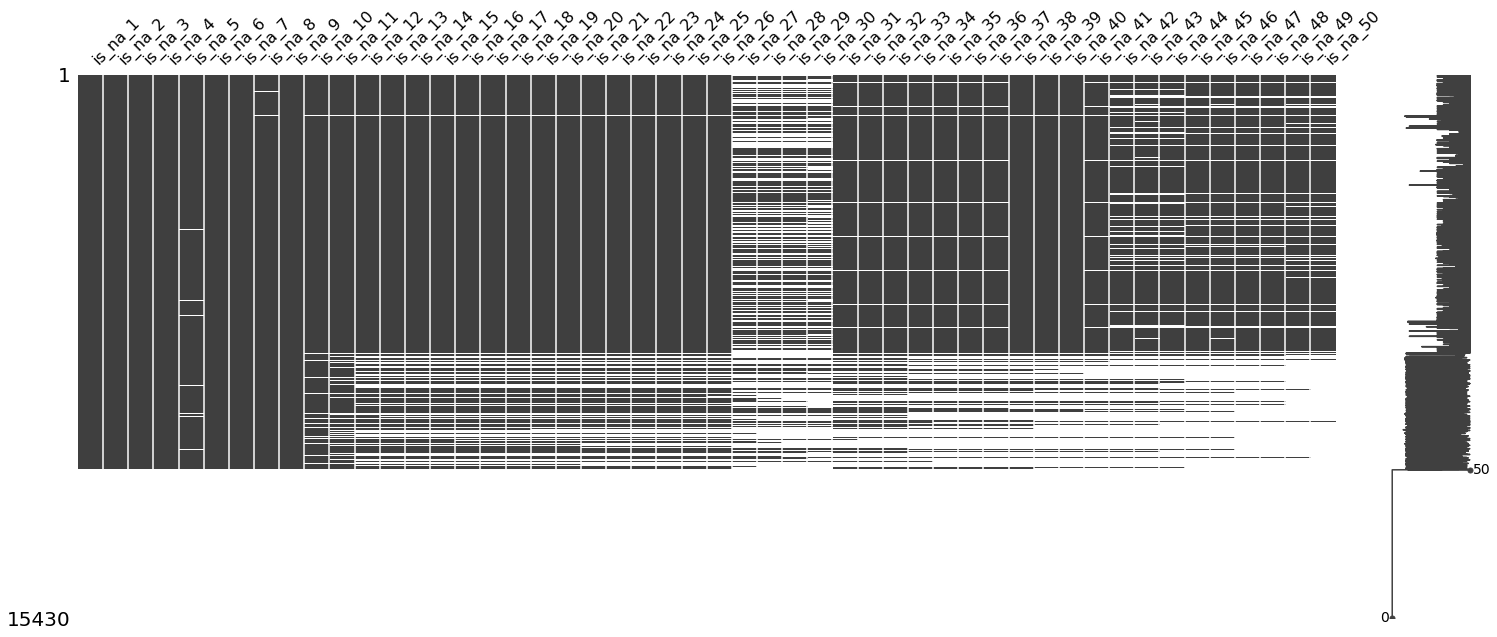

In [14]:
msno.matrix(salary_nandf)

**Bar Plot**  
The bar plot shows the trend in missing data, showing how many data are missing in each column. The x axis are the question, and the y axis are percent of missing data, ranging from 0 to 1.

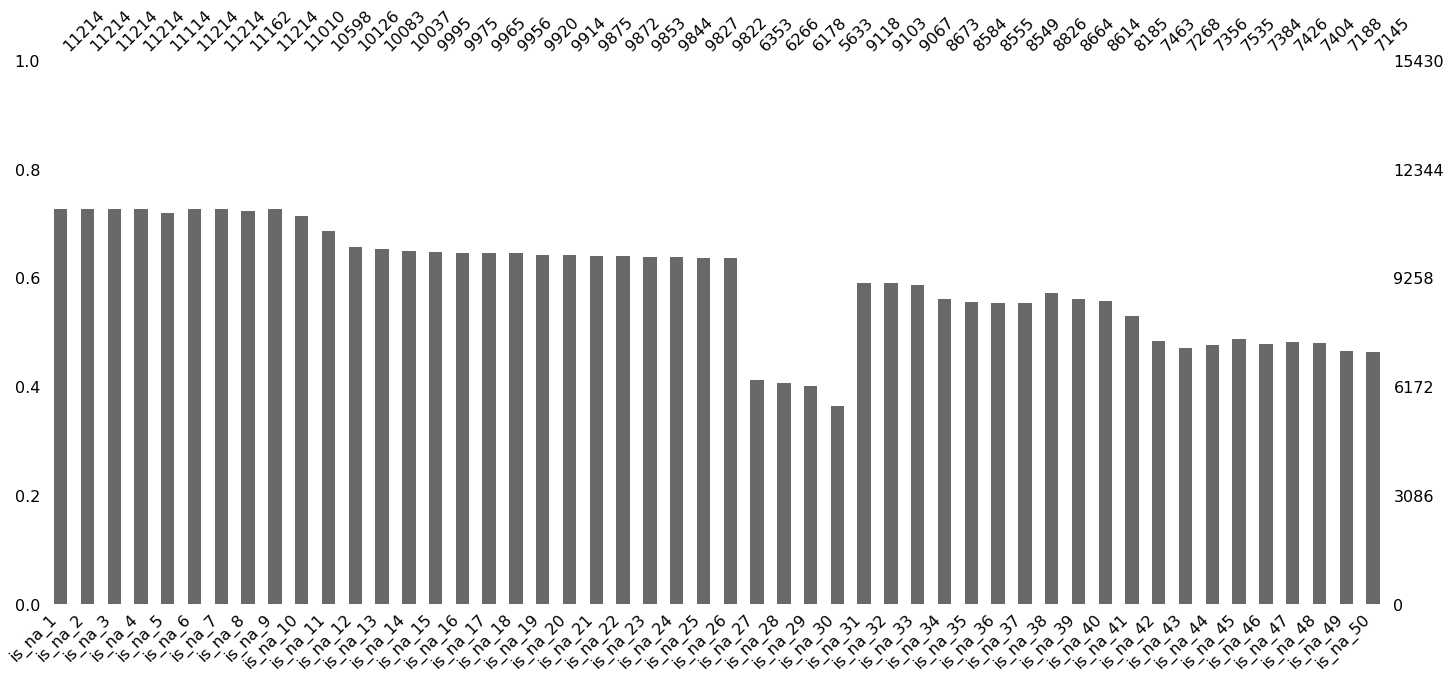

In [15]:
msno.bar(salary_nandf)

**Heat Map**  
This heat map shows how strongly the presence or absence of one variable affects the presence of another.

Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).

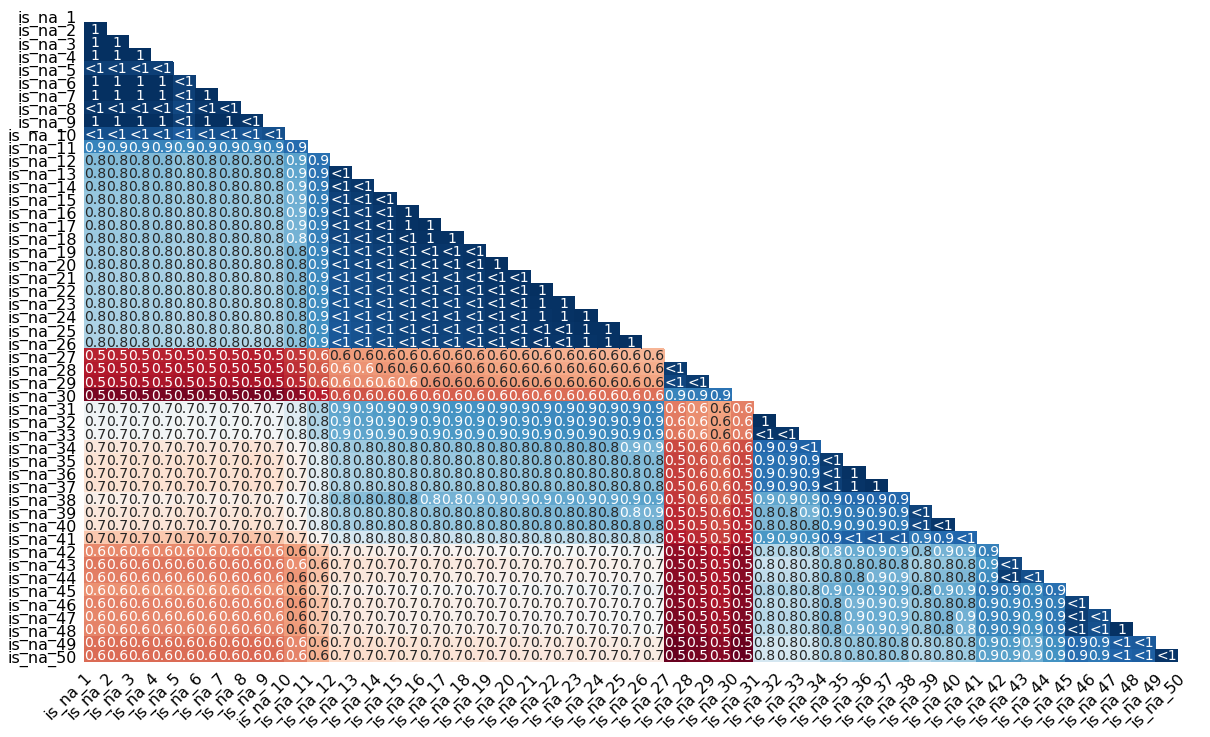

In [16]:
msno.heatmap(salary_nandf)

The 3 graphs above looks at the missing values of each question. These are used to give a brief understanding of why the values are missing, however, this is not explored in detail as it is not the focus of this analysis. 

- From both the matrix graph and the bar graph, it is shown that there are increasing number of missing values as people progress in the survey. This is likely due to people's patience on answering the survey wears out as they continue. This likely means that the survey is too lenghty, thus people are leaving before finishing it.
- The matrix map shows that the missing entries are concentrated in the higher indexed entries. This suggests that there was likely some sorting performed on the raw dataset.
- In previous iterations of data cleaning, the bar graph showed a few dips in response rate for some of the questions. These questions were 17,20,22,27-30,32 and 37.These were all questions that ask the respondants to pick a *most ___* type question. It is likely that it is difficult for answerers to do so, thus these types of questions are skipped.
- The missing questions are likely not only because of respondants losing interest over time. This is suggested by both the bar graph and the color trend shown in the heat map.
- Q27-30 are questions that asks about which products that the repondants use. These are skipped likely because there is a student population answering this survey, which whom does not use any products.

The data entries with missing answers will be droped instead of filled in with a value due to the columns that had missing values are *select multiple* type questions, and the number of choices for each questions are different, therefore, using common practice such as filling it with the mode does not apply. Additionally, the answers in this data set is likely correlated to one another, thus willing the nan with a value will likely reduce the performance of the model.

In [17]:
# Dropping Number Data points that were skipped
print('Original Number of Data: '+str(len(salary)))

for x in range (1,51): #checking all 50 questions
    q_key= 'Q'+str(x)
    col_name_na='is_na_'+str(x)

#     for columns of Q1, remove that row if it has a nan value
    try:
        salary.drop(salary[salary[col_name_na]==True].index, inplace=True)
    except:
        pass

print('Current Number of Data: ' + str(len(salary)))

Original Number of Data: 15430
Current Number of Data: 12198


### 1.2 Cleaning up Nationality Data

There were 56 different options for nationality. This resulted in many of the nationtionality to be very granular. Including all the countries in the dataset would make result the input to the model having a very high dimension, taking the model into the "curse of dimensionality" territory, making the model more likely to overfit, and taking longer to solve. To alleviate this issue, countries with very little datapoints are removed.

In [18]:
#defining a function for making bar plots
def barplot(df,
            x_data,
            y_data,
            title='Title',
            x_label='x_axis',
            y_label='y_axis',
            rotate=45,
            font_size=16,
            label_size=12):

    sns.set(rc={'figure.figsize':(14.7,11.27)})
    ax2=sns.barplot(x=x_data, y=y_data, data=df)

    for item in ax2.get_xticklabels():
        item.set_rotation(rotate)

    ax2.axes.set_title(title,fontsize=font_size+2)
    ax2.set_xlabel(x_label,fontsize=font_size)
    ax2.set_ylabel(y_label,fontsize=font_size)
    ax2.tick_params(labelsize=label_size)

In [19]:
# dropping the na count column as its no longer useful
drop=[]
for col in salary.columns:
    if (col[:5]=='is_na'):
        drop.append(col)
salary = salary.drop(columns=drop)

# dropping the row that's holding the questions
salary=salary.iloc[1:]

#set Q9 to float for plotting
salary.Q9=salary.Q9.astype(float);

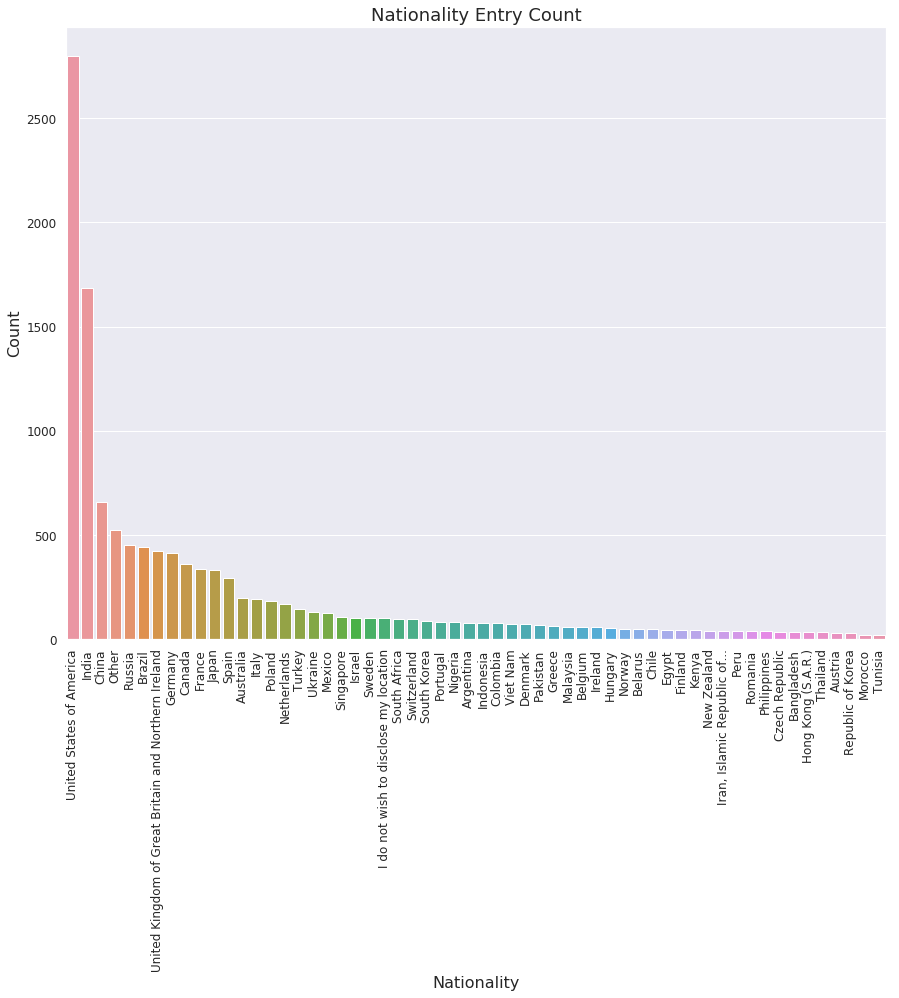

In [20]:
salary_dist = salary.groupby(by='Q3', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot(salary_dist,'Q3','Q9','Nationality Entry Count','Nationality','Count',90)

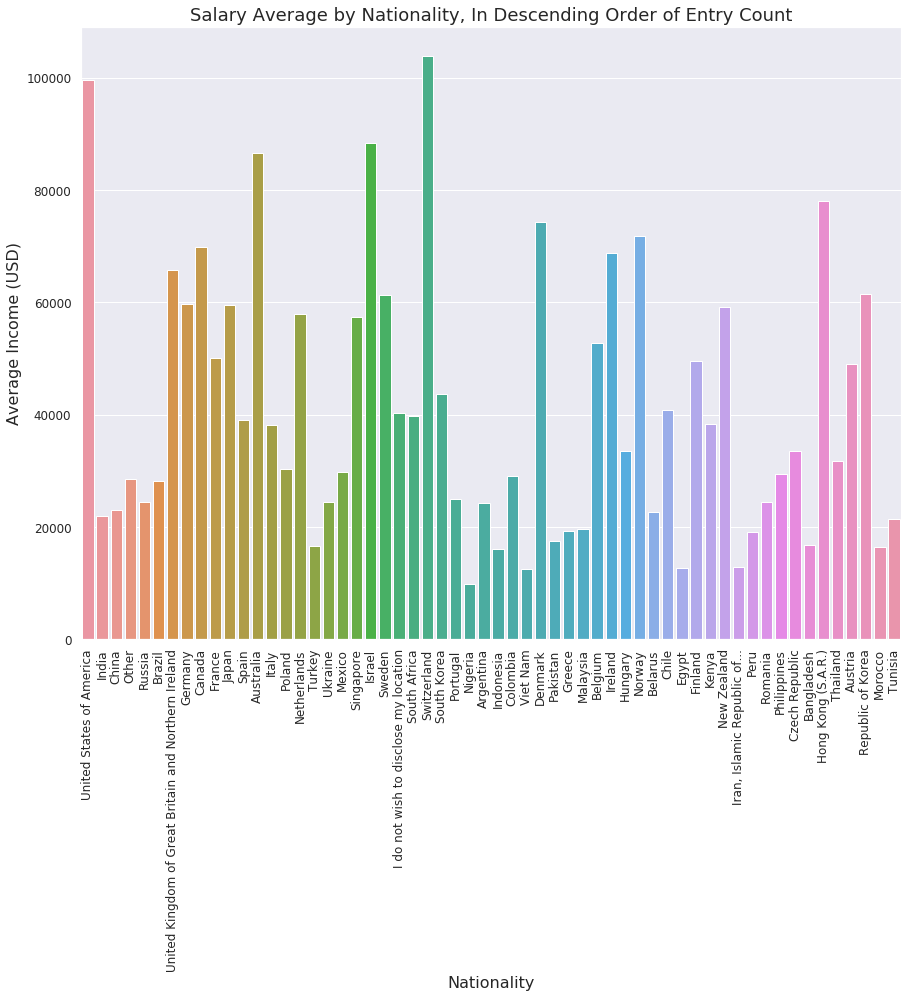

In [21]:
# salary_dist2 = salary.groupby(by='Q3', as_index=False).agg({'Q9': pd.Series.mean})
count_tmp=salary_dist.index.tolist()
salary_dist2=salary.groupby(['Q3'],as_index=False).mean()
salary_dist2=salary_dist2[['Q3','Q9']]
salary_dist2=salary_dist2.reindex(count_tmp)
barplot(salary_dist2,'Q3','Q9','Salary Average by Nationality, In Descending Order of Entry Count','Nationality','Average Income (USD)',90,16)

Looking at the **Nationality Entry Count** graph, the countries after spain have very little data count, around ~200. These are not enough data to make a good prediction. To remedy this, can either group many of the countries that does not have enough data entry into another group: 'other'. However, looking at the **Average Income by Nationality** graph, the countries have a very wide range of average income. This means if grouping these would cause the income for the 'other' category to have a very large range of values, heavily disturbing any trend that exists the country feature. 

Therefore, the countries that has less than 200 data points, and the "Other" category are dropped.

In [22]:
ndrop=salary_dist[(salary_dist.Q9>300)].Q3.tolist()
print(ndrop)
ndrop.remove('Other')
print(ndrop)
print ('Number of data points remained after cleaning countries:' + str(len(salary[salary.Q3.isin(ndrop)]))+'/'+str(len(salary)))
salary=salary[salary.Q3.isin(ndrop)]

['United States of America', 'India', 'China', 'Other', 'Russia', 'Brazil', 'United Kingdom of Great Britain and Northern Ireland', 'Germany', 'Canada', 'France', 'Japan']
['United States of America', 'India', 'China', 'Russia', 'Brazil', 'United Kingdom of Great Britain and Northern Ireland', 'Germany', 'Canada', 'France', 'Japan']
Number of data points remained after cleaning countries:7910/12197


### <u><a name="1.3">1.3 Encoding Data</a></u>
There are the following types of categorical data encoding (description of 4-7 are quoted from [source](http://www.statsmodels.org/devel/contrasts.html)):

1. **Ordinal Data encoding:** order categories into intergers that represent the order of the category, maintains the sequence between each category after encoding.
- **OneHot encoding:** having one column for each value to compare vs all other values. Lose the information on the sequence between each categorical data after encoding.
- **Binary:** Order categories into ordinal data, then convert each integer to binary digits of yes and no with separate columns. This encodes the data in fewer dimensions than one-hot.
- **Sum Coding:**  compares the mean of the dependent variable for a given level to the overall mean of the dependent variable over all the levels.
- **Polynomial:** The coefficients taken on by polynomial coding for k=4 levels are the linear, quadratic, and cubic trends in the categorical variable. The categorical variable here is assumed to be represented by an underlying, equally spaced numeric variable.
- **Backward Difference:** the mean of the dependent variable for a level is compared with the mean of the dependent variable for the prior level. This type of coding may be useful for a nominal or an ordinal variable.
- **Helmert:** The mean of the dependent variable for a level is compared to the mean of the dependent variable over all previous levels. Hence, the name ‘reverse’ being sometimes applied to differentiate from forward Helmert coding.

In this dataset, there is a mix of nominal, and ordinal data types. **Binary encoding** and **OneHot encoding** strategy were considered, because other coding methods such as ordinal data encoding does not apply too well to this dataset, furthermore, the test conducted by [Beyong One-Hot: an exploration of categorical variables, Mushroom Dataset](https://www.kdnuggets.com/2015/12/beyond-one-hot-exploration-categorical-variables.html) suggest that OneHot and Binary encoding would give the best model prediction performance.

Reason that binary the encoding method was considered is because binary encoding would result in less dimensions (columns) in the encoded dataset. The concept of the "curse of dimensionality" says that high-dimension space (many columns) require more parameters (more rows) for the model to understand. Given that there aren't that many rows and many rows in the cleaned dataset, the model should perform better if it has less columns. 

A preliminary test was conducted on the Binary encoding and OneHot encoding method to compare the model performance. This test showed that OneHot gives a slightly better model prediction performance. Thus **the remaining analysis used OneHot encoding**.

In [23]:
y = salary.Q9
X = salary.drop(columns=['Q9','Q9_entry_counts'])
col_to_enc=X.columns.values.tolist()

for i in col_to_enc:
    if (i[-12:]=='entry_counts'): 
        col_to_enc.remove(i)
    
# # use binary encoding to encode two categorical features
enc = BinaryEncoder(cols=col_to_enc).fit(X, y)

# # transform the dataset
salary_binarized = enc.transform(X)
salary_binarized_y=y

In [24]:
salary_binarized.head()

,Q1_0,Q1_1,Q1_2,Q2_0,Q2_1,Q2_2,Q2_3,Q2_4,Q3_0,Q3_1,...,Q20_entry_counts,Q21_entry_counts,Q22_entry_counts,Q23_entry_counts,Q24_entry_counts,Q25_entry_counts,Q26_entry_counts,Q31_entry_counts,Q32_entry_counts,Q33_entry_counts
index,,,,,,,,,,,,,,,,,,,,,
1.0,0,0,1,0,0,0,0,1,0,0,...,1,3,1,1,1,1,1,4,1,3
2.0,0,1,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4.0,0,1,0,0,0,0,1,1,0,0,...,1,4,1,1,1,1,1,4,1,3
6.0,0,1,0,0,0,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
8.0,0,1,0,0,0,1,0,1,0,0,...,1,2,1,1,1,1,1,4,1,4


In [25]:
salary_onehot=pd.get_dummies(salary)

In [26]:
salary_onehot.shape

(7910, 354)

## Step 2: Exploratory Data Analysis

In this step, there are 3 types of graphical figures generated, each is meant to visualize a different trend inside the dataset.
1. **Multiple Question Entry Count Plot Vs Salary Mean:** for visualizing the relationship between number of entry picked for the multiple choice questions and the average salary. 
2. **Question Unique Response vs Salary Mean:** for visualizing what is the Salary trend when looking at each question response independently from the rest of the dataset.
3. **Feature Importance Graph:** for visualizing the feature importance, how well each feature (column) predicts the target (salary).

A heatmap with correlation between each category is not presented here, due to the presence of multiple choice questions, which cause one question to be split into multiple columns. Thus a heat map that is supposed to demonstrate the correlation between each feature would not mean much because there would be some many columns that only represent part of the a feature.

### 2.1 Visualizing Multiple Question Entry Count Plot Vs Salary Mean

A graph is plotted here for visualizing the relationship between the number of entry picked for the multiple choice question and the average salary. The number of entry picked columns are generated in the data cleaning step. 

The multiple choice questions are generally about "for X, pick all that apply". The idea here is that generally speaking, the more tools that the respondant know, such as knowing how to use 4 different machine learning libraries vs. knowing only 1 machine learning libraries would result in different average salaries. These graphs are arranged in a 3x3 grid, such that it is easy to make the compairson between the trends seen in each of the different graphs. 

The length of the bar represents the average salary for that group. Though it must be noted that number of people who picked 4 options would be different than number of people who picked 1 option. Thus the standard deviation line on each bar is useful to know the variance of the mean shown. 

In [27]:
#renaming the column name Q12_MULTIPLE_CHOICE to Q12. 
#This column name did not follow convention of the other column names
salary=salary.rename(index=str, columns={"Q12_MULTIPLE_CHOICE": "Q12"})

#preparing a dataframe for plotting correlation between number of choice selected and salary level
tmp_col=[]

#getting all the entry count columns
for x in range (1,51): #checking all 50 questions
    q_key= 'Q'+str(x)+'_entry_counts'
    if q_key in salary.columns.values:
        tmp_col.append(q_key)
count_df=salary[tmp_col]
tmp_list=count_df.columns.values.tolist()
tmp_col=[]

#removing all the columns that arent multiple choice
for col in tmp_list:
    if ((count_df[col].mean() == 1) and (count_df[col].std()==0)):
        tmp_col.append(col)
count_df=count_df.drop(columns=tmp_col)
count_df_list=count_df.columns.values.tolist()
count_df['Q9']=salary['Q9']

#selecting all columns that are chose one type questions
for i in range(len(tmp_col)):
    tmp_col[i]=tmp_col[i][:-13]
count_df_one=salary[tmp_col]

In [28]:
#Setting up the dataframe that contains all multiple choice questions for plotting 

#Renaming the data entry title to a brief description
q_dict={'Q11_entry_counts':'Work Activities',
        'Q13_entry_counts':'IDEs',
        'Q14_entry_counts':'Hosted Notebooks',
        'Q15_entry_counts':'Cloud Computing Services',
        'Q16_entry_counts':'Programming Languages',
        'Q19_entry_counts':'ML Frame Works',
        'Q21_entry_counts':'Visualization Libs',
        'Q31_entry_counts':'Data Types',
        'Q33_entry_counts':'Dataset Sources'
       }

for i in count_df_list:
    tmp=count_df[[i,'Q9']]
    tmp['Q']=q_dict[i]
    tmp.columns=['count','salary_mean','Q']
    try:
        plot_df=pd.concat([plot_df,tmp], ignore_index=True)
    except:
        plot_df=tmp

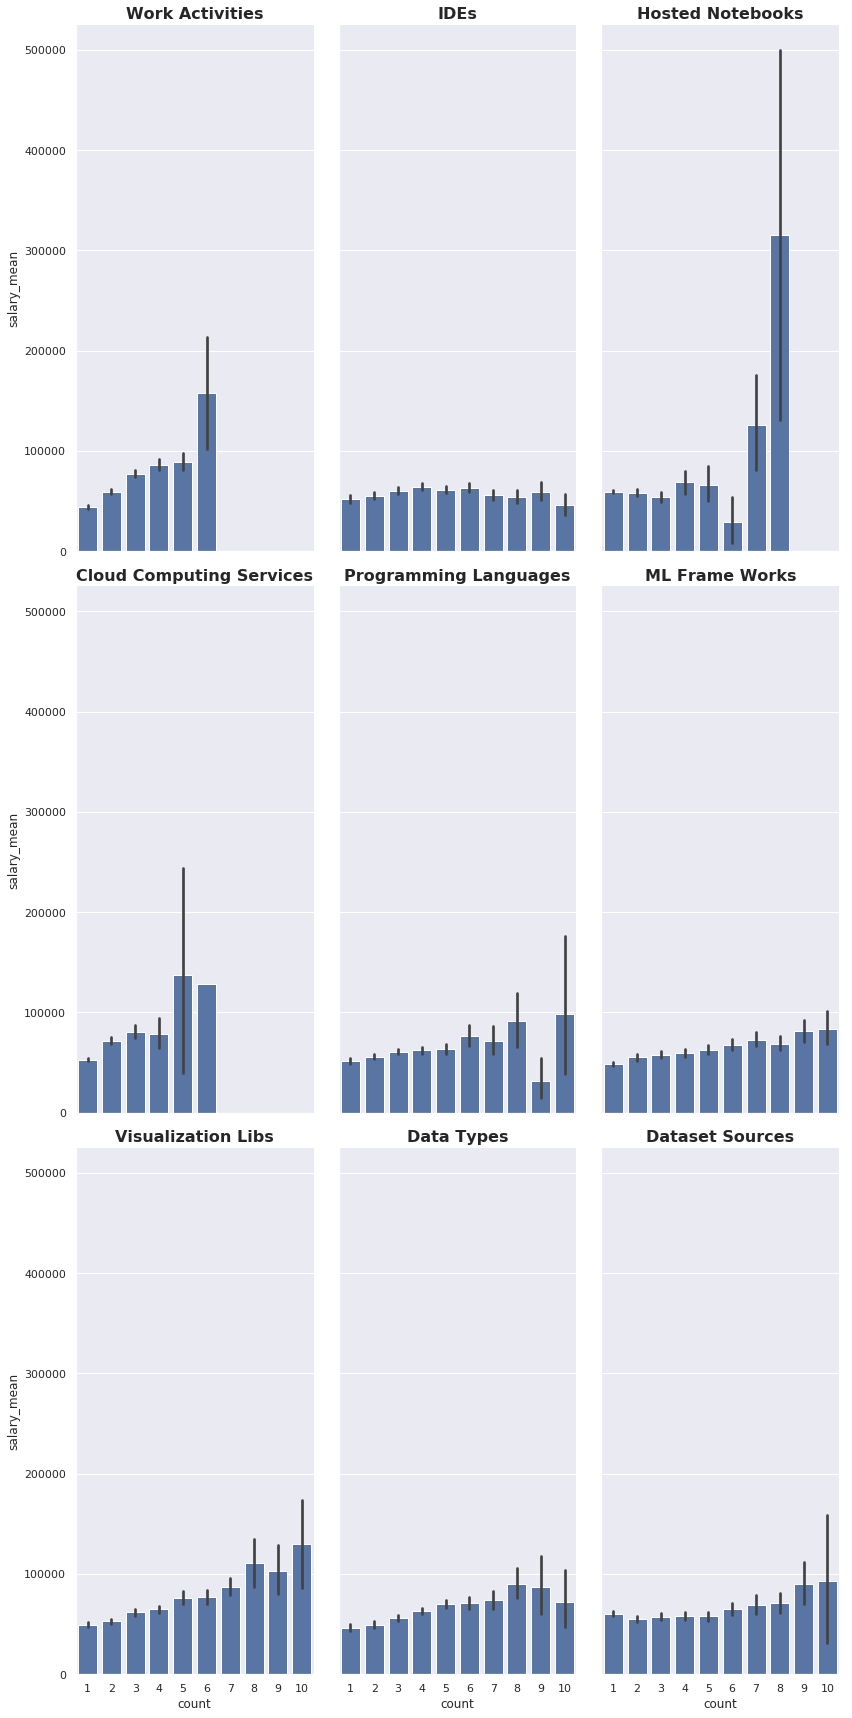

In [29]:
#plotting the graph using sns Facet Grid
g=sns.FacetGrid(plot_df, col='Q',height=8, aspect=.5, col_wrap=3)
with sns.plotting_context(font_scale=10):
    g.map(sns.barplot,'count','salary_mean')
    g.set_titles(col_template="{col_name}", fontweight='bold', fontsize=16)

This graph shows that there is a general trend that the more tools that the respondant know, the more salary the respondant is likely to have. Most of the graphs shown above is related to a tool. 

This trend fits with the intuititive understanding of worker skill: the more tools someone knows how to you, the broader the person's skill set is, meaning employers value that person more. 

Furthermore, note that as number of count increase for each graph, the standard deviation grows. This aligns with the idea that not that there are less people knowing how to use a very large number of tools, thus the responded average salary would have a large variation.

### 2.2 Visualizing Unique Response in Each Question vs Salary Mean

Here we visualize the average salary trend for each question, independent of other questions of the dataset. This allows the vlisualization of the salary trend that gets affected by each of the categories. Giving a better understanding of how salary is affected. 

In [30]:
#defining a function for making bar plots
def barplot_with_count(df,
            x_data,
            y_data,
            title='Title',
            x_label='x_axis',
            y_label='y_axis',
            rotate=45,
            font_size=10,
            label_size=8):

    sns.set(rc={'figure.figsize':(8,4)})
    ax2=sns.barplot(x=x_data, y=y_data, data=df)

    for item in ax2.get_xticklabels():
        item.set_rotation(rotate)

    ax2.axes.set_title(title,fontsize=font_size+2)
    ax2.set_xlabel(x_label,fontsize=font_size)
    ax2.set_ylabel(y_label,fontsize=font_size)
    ax2.tick_params(labelsize=label_size)

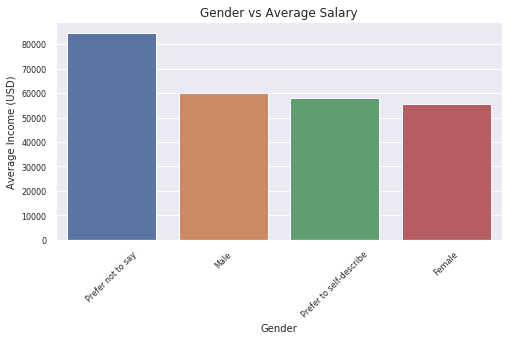

In [31]:
salary_dist = count_df_one.groupby(by='Q1', as_index=False).agg({'Q9': pd.Series.mean})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)
barplot_with_count(salary_dist,'Q1','Q9','Gender vs Average Salary','Gender','Average Income (USD)')

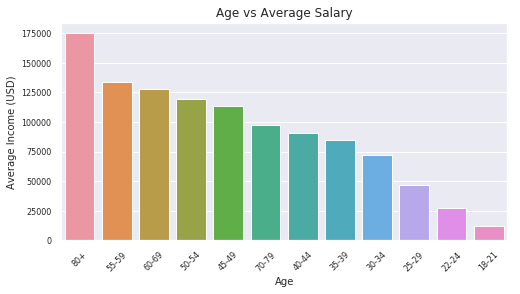

In [32]:
salary_dist = count_df_one.groupby(by='Q2', as_index=False).agg({'Q9': pd.Series.mean})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)
barplot_with_count(salary_dist,'Q2','Q9','Age vs Average Salary','Age','Average Income (USD)')

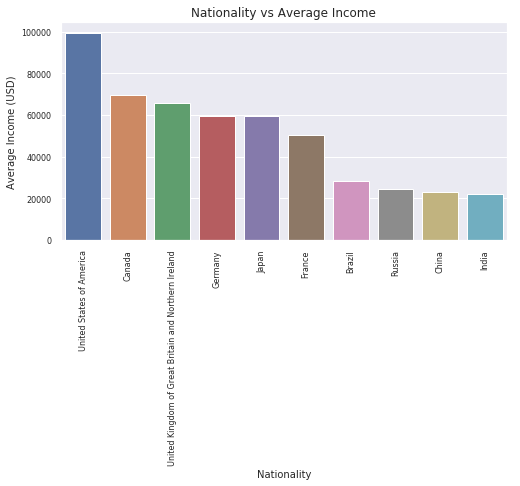

In [33]:
salary_dist = count_df_one.groupby(by='Q3', as_index=False).agg({'Q9': pd.Series.mean})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q3','Q9','Nationality vs Average Income','Nationality','Average Income (USD)',90)

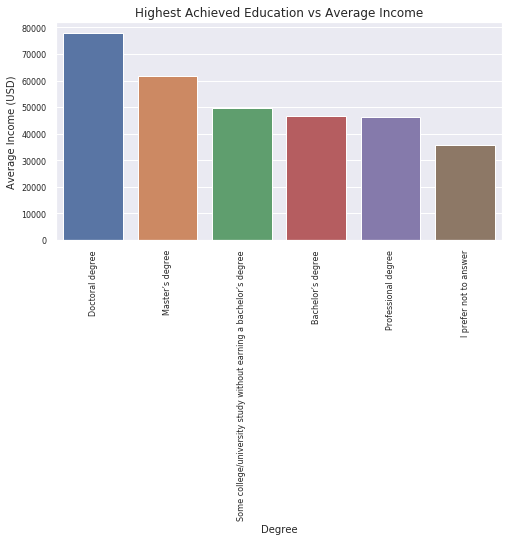

In [34]:
salary_dist = count_df_one.groupby(by='Q4', as_index=False).agg({'Q9': pd.Series.mean})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q4','Q9','Highest Achieved Education vs Average Income','Degree','Average Income (USD)',90)

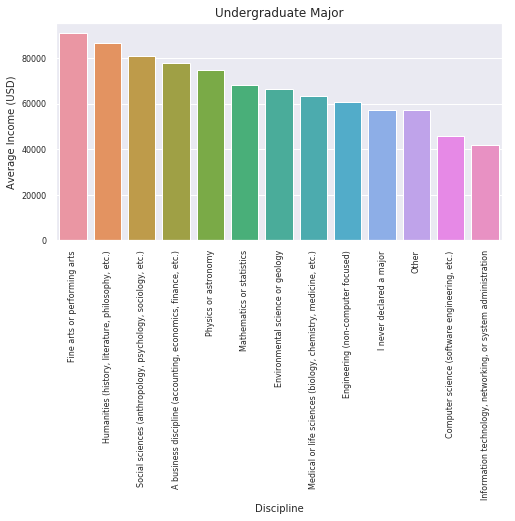

In [35]:
salary_dist = count_df_one.groupby(by='Q5', as_index=False).agg({'Q9': pd.Series.mean})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q5','Q9','Undergraduate Major','Discipline','Average Income (USD)',90)

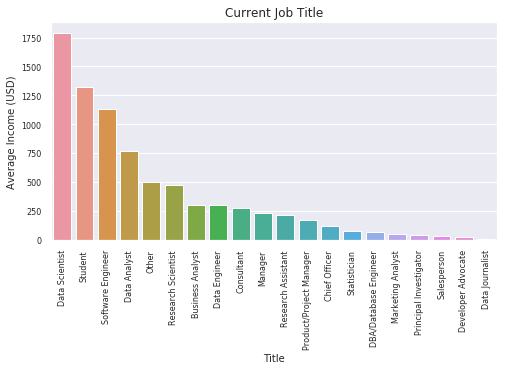

In [36]:
salary_dist = count_df_one.groupby(by='Q6', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q6','Q9','Current Job Title','Title','Average Income (USD)',90)

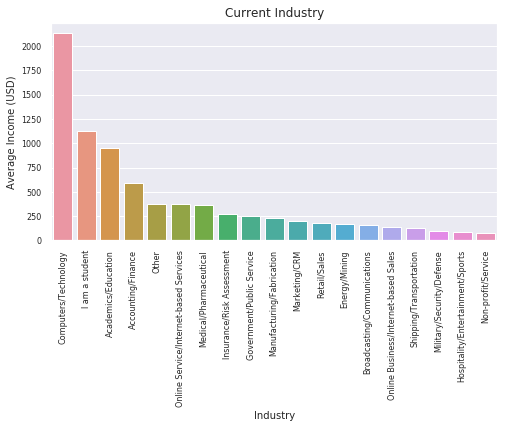

In [37]:
salary_dist = count_df_one.groupby(by='Q7', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q7','Q9','Current Industry','Industry','Average Income (USD)',90)

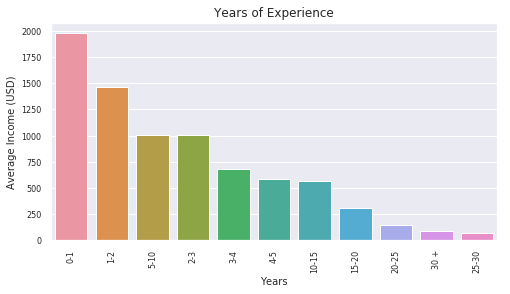

In [38]:
salary_dist = count_df_one.groupby(by='Q8', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q8','Q9','Years of Experience','Years','Average Income (USD)',90)

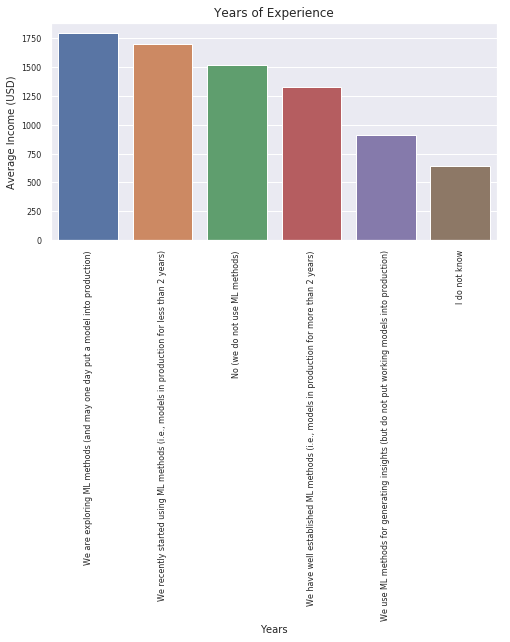

In [39]:
salary_dist = count_df_one.groupby(by='Q10', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q10','Q9','Years of Experience','Years','Average Income (USD)',90)

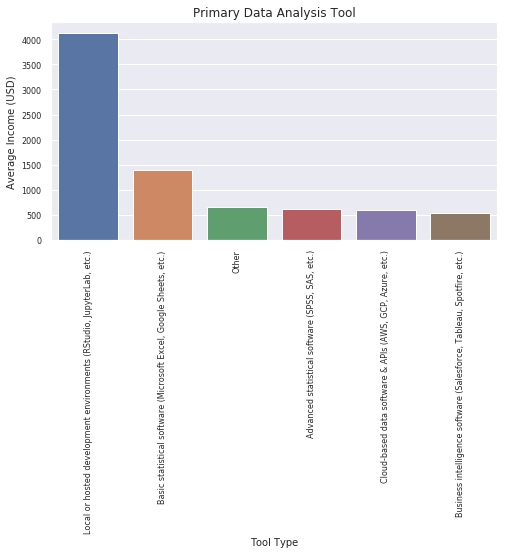

In [40]:
salary_dist = count_df_one.groupby(by='Q12', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q12','Q9','Primary Data Analysis Tool','Tool Type','Average Income (USD)',90)

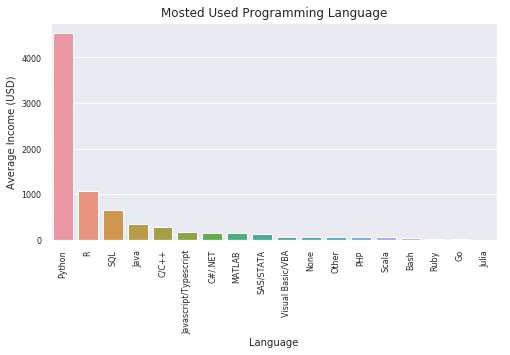

In [41]:
salary_dist = count_df_one.groupby(by='Q17', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q17','Q9','Mosted Used Programming Language','Language','Average Income (USD)',90)

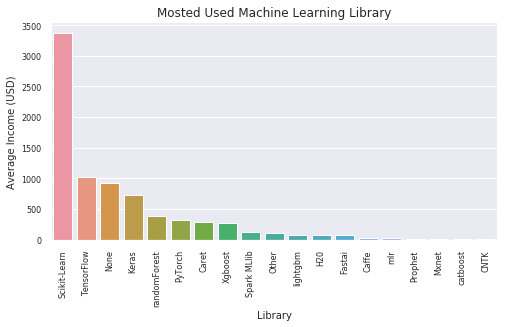

In [42]:
salary_dist = count_df_one.groupby(by='Q20', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q20','Q9','Mosted Used Machine Learning Library','Library','Average Income (USD)',90)

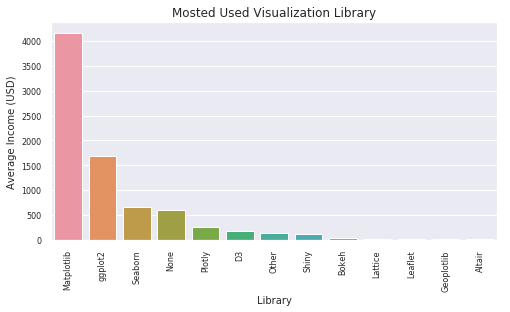

In [43]:
salary_dist = count_df_one.groupby(by='Q22', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q22','Q9','Mosted Used Visualization Library','Library','Average Income (USD)',90)

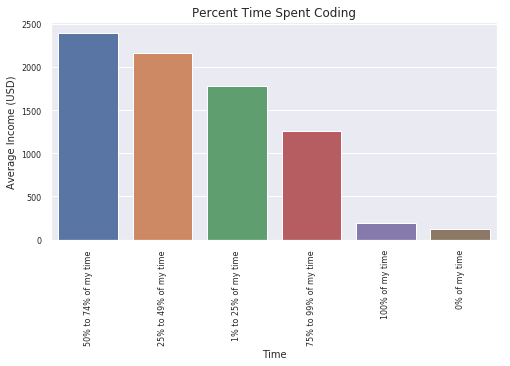

In [44]:
salary_dist = count_df_one.groupby(by='Q23', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q23','Q9','Percent Time Spent Coding','Time','Average Income (USD)',90)

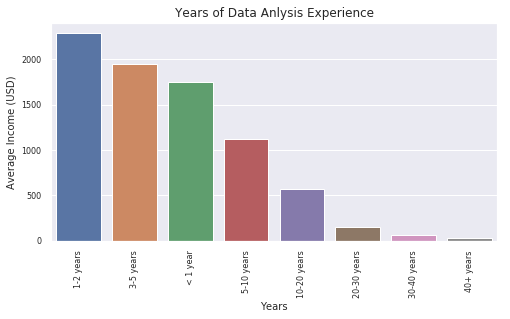

In [45]:
salary_dist = count_df_one.groupby(by='Q24', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q24','Q9','Years of Data Anlysis Experience','Years','Average Income (USD)',90)

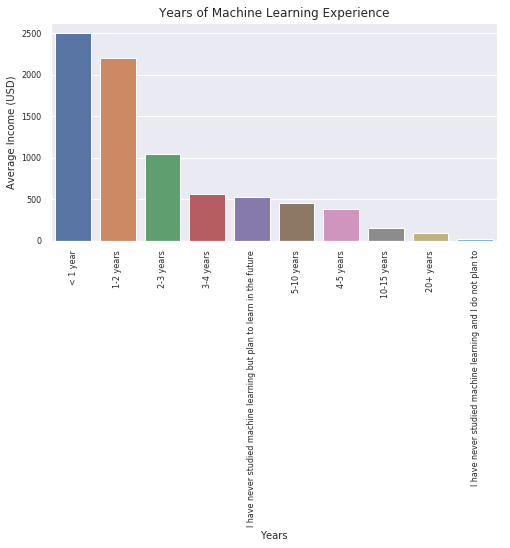

In [46]:
salary_dist = count_df_one.groupby(by='Q25', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q25','Q9','Years of Machine Learning Experience','Years','Average Income (USD)',90)

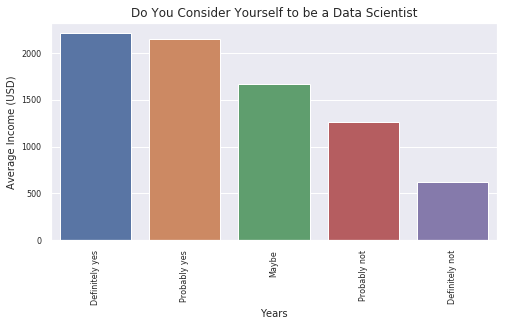

In [47]:
salary_dist = count_df_one.groupby(by='Q26', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q26','Q9','Do You Consider Yourself to be a Data Scientist','Years','Average Income (USD)',90)

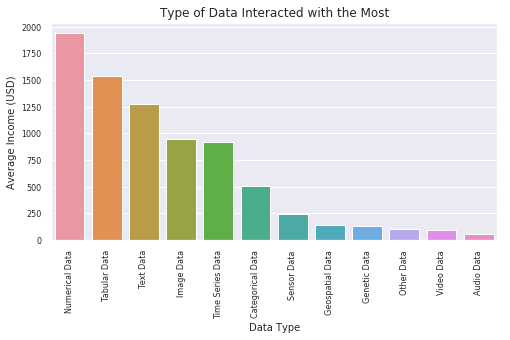

In [48]:
salary_dist = count_df_one.groupby(by='Q32', as_index=False).agg({'Q9': pd.Series.count})
salary_dist  = salary_dist.sort_values(by='Q9', ascending=False)

barplot_with_count(salary_dist,'Q32','Q9','Type of Data Interacted with the Most','Data Type','Average Income (USD)',90)

### 2.3 Visualizing Feature Importance Correlation

A feature importance graph that plots out how well each feature predicts the end salary compensation requires a modeling done to find out how well each feature predicts the target. 

To plot this graph, the list of feature importance must be first obtained. This list is obtained through fitting a random forest regressor with default parameters over the entire dataset, then extract the top 30 most important features and their respective feature imporatance score.

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

In [50]:
# fitting a random forest regressor to get its feature importance list
y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])

X = salary_onehot.drop(columns=['Q9','Q9_entry_counts'])
#fitting the model
clf = RandomForestRegressor(random_state=42,verbose=1,n_jobs=-1)  
clf.fit(X, y) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=1, warm_start=False)

In [51]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
feature_list = list(salary_onehot.drop(columns=['Q9','Q9_entry_counts']))

feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# extract the feature importance list for plotting correlation graph
feature=[]
importance= []
for i in range(30):
    feature.append(feature_importances[i][0])
    importance.append(feature_importances[i][1])


In [52]:
feature[2]='Q10_We have well established'
feature[-2]='Q11_Part_4_Build prototypes'

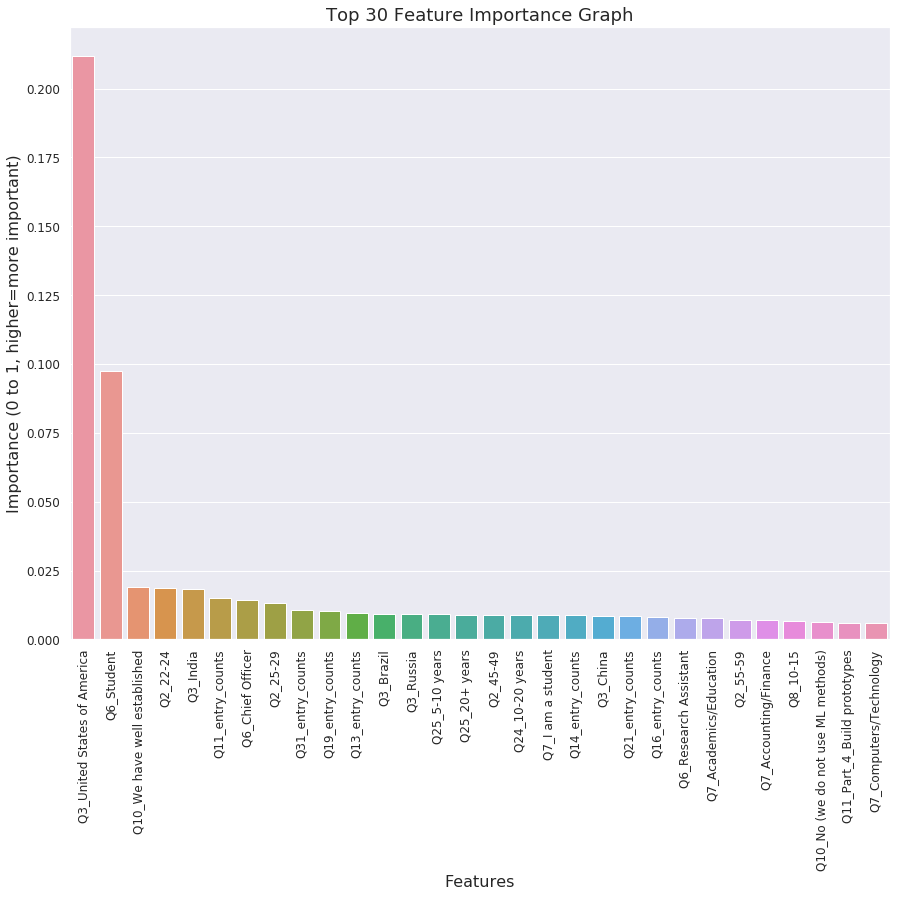

In [53]:
#plotting the feature importance correlation graph
d={'feature':feature,'importance':importance}
feature_importance_df=pd.DataFrame(data=d)

barplot(feature_importance_df,'feature','importance','Top 30 Feature Importance Graph','Features','Importance (0 to 1, higher=more important)',90)

From the feature importance correlation graph above, it is shown that the following original attributes are the best predictor: (1) Being in USA, (2) Being a Student, (3) Having well established ML Model, (4) Age 22-24, and (5) being in India.

5 questions have features in the top feature importance predictor.

1. Q3: In which country do you currently reside?
2. Q6: Select the title most similar to your current role (or most recent title if retired): - Selected Choice
3. Q10: Does your current employer incorporate machine learning methods into their business?
4. Q2: What is your age (# years)?
5. Q11: Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions

Note that most of these question are asked near the beginning of the survey, and are not *pick all that apply* type of multiple choice questions. This means that these question have a high response rate and less categories relative the the rest of the dataset. 

Most top predictors such as being in USA, student, and age 22-24 is a good predictor is likely due to it has the highest number of respondant associated with it. Similarily with being a Student, which also have a high number of respondants. 

This plot suggests that quesitions and columns that have a high amount of data points associated with it is a good predictor. This also makes intuitive sense, because a high amount of data points means that the standard deviation on the target for that feature would be low, thus it is easier for the model to learn the relation between that feature and the likely target.

## Step 3: Feature Selection

Feature Engineering is a very useful in data science, because getting the best model prediction often is not about which model is used, but rather what goes into the model. Using the popular saying: "garbage in, garbage out", if what goes into the model is not a good set of features to predict the target with, then the end result would also be bad. Feature engineering consist of **feature creation** and **feature selection**. Creating features means that finding a trend that is truely a good predictor for the target. Selecting features means that only picking out the useful set of features to the model, which would reduce training time, and getting better model performance because the model would not be swayed by bad predictors. 

There are generally three types of feature selection methods.
1. **Filter Methods:** This method is generally a preprocssing step, the selecting of features is independent of any algorithm, using a set of statistic tests.
2. **Wrapper Methods:** This method uses a learning algorithm to fit the entire dataset, then most important features are found by selecting the features with the highest importance score that is above a threshold. 
3. **Embedded Methods:** This method uses a learning algorithm that has a inherent feature selection method. Such as regularized regression. 

For this analysis, 3 feature selection methods was tested.
1. **Boruta Feature Selection(wrapper method):** A custom library that recursively use randomly generated features to as a compairson against the features inside the dataset to confirm whether the feature inside the dataset is useful or not.
2. **Select From Model with Extra Tree Regressor(wrapper method):** using extra tree regressor, to select the best features based on a threshold.
3. **Analysis of Variance Method(filter method):** uses analsys of variance technique that determine and selects the K best features. 

To preliminarily test which feature selection method is the best for this analysis, the selected features from each algorithm were fed into a orinary squares linear regression model with default parameters to see how well the model performs. The best feature selection method is then further optimized. Linear regression is selected because it has a closed form solution, thus reducing factors that could affect the model performance.

A unselected set of features was also fed into linear regression to serve as a benchmark.

It was found that the **Select From Model with Extra Tree Regressor** gave the best model performance.

In [54]:
# Here a function is defined to generate a report on the model performance. 

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_validate
scoring = ['r2', 
           'neg_mean_absolute_error',
           'explained_variance']

def regression_report (y_test=None,y_pred=None,cv=None,print_cv=False):
    
    if (not print_cv):
        print('Model Result:')
        print('Mean Absolute Error: %0.2f' % (mean_absolute_error(y_test, y_pred)))
        print('Explained Variance: %0.2f' % (explained_variance_score(y_test, y_pred)))
        print('R2 Score: %0.2f' % (r2_score(y_test, y_pred)))

        d={'predicted':y_pred,'true':y_test}
        predicted=pd.DataFrame({'predicted':y_pred,'true':y_test.Q9})
        predicted['Absolute Error']=predicted['predicted']-predicted['true']

        display(predicted.describe())
    
    if print_cv:
        print("---------------------------")
        print('Cross Validated Result for 95 percent confidence interval:')
        print('Time Elapsed: %0.2fs' % (cv['fit_time'].sum()))
        
        print("")
        print("Training Mean Absolute Error: %0.2f (+/- %0.2f)" % (cv['train_neg_mean_absolute_error'].mean()*-1, cv['train_neg_mean_absolute_error'].std()*2))
        print('Training Explained Variance: %0.2f (+/- %0.2f)' % (cv['train_explained_variance'].mean(),cv['train_explained_variance'].std()*2) )
        print('Training R2 Score: %0.2f (+/- %0.2f)' % (cv['train_r2'].mean(),cv['train_r2'].std()*2))
        
        print("")
        print("Test Mean Absolute Error: %0.2f (+/- %0.2f)" % (cv['test_neg_mean_absolute_error'].mean()*-1, cv['test_neg_mean_absolute_error'].std()*2))
        print('Test Explained Variance: %0.2f (+/- %0.2f)' % (cv['test_explained_variance'].mean(),cv['test_explained_variance'].std()*2) )
        print('Test R2 Score: %0.2f (+/- %0.2f)' % (cv['test_r2'].mean(),cv['test_r2'].std()*2))
        print("---------------------------")

#### 3.1 BorutaPy – an all relevant feature selection method

In [55]:
%%skip $marking

from boruta import BorutaPy
 
y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = salary_onehot.drop(columns=['Q9','Q9_entry_counts'])

y=y.values
X=X.values

print('Dataframe Shape Before Feature Selection: '+ str(X.shape))
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
forest = RandomForestRegressor(n_jobs=-1)
 
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2)
 
# find all relevant features
feat_selector.fit(X, y)
 
# check selected features
feat_selector.support_
 
# check ranking of features
feat_selector.ranking_
 
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)
print('Dataframe Shape After Feature Selection: '+ str(X_filtered.shape))             


In [56]:
%%skip not $marking

print("""\
BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	348
Dataframe Shape After Feature Selection: (7910, 3)
""")

BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	348
Dataframe Shape After Feature Selection: (7910, 3)



#### 3.2 Wrapper Method: Select from Random Forest

In [57]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

#threshold found in step 3.5

y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = salary_onehot.drop(columns=['Q9','Q9_entry_counts'])

print('Dataframe Shape Before Feature Selection: '+ str(X.shape))

clf = ExtraTreesRegressor(n_estimators=50, n_jobs=-1, random_state=42)
clf = clf.fit(X, y)

model = SelectFromModel(clf, prefit=True, threshold='0.6221591*mean')
X_rf_selected = model.transform(X)
print('Dataframe Shape After Feature Selection: '+ str(X_rf_selected.shape))

Dataframe Shape Before Feature Selection: (7910, 352)
Dataframe Shape After Feature Selection: (7910, 125)


#### 3.3 Filter Method: Analysis of Variance

In [58]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = salary_onehot.drop(columns=['Q9','Q9_entry_counts'])

print('Dataframe Shape Before Feature Selection: '+ str(X.shape))

X_ANOVA_selected = SelectKBest(f_regression).fit_transform(X, y)
print('Dataframe Shape After Feature Selection: '+ str(X_ANOVA_selected.shape))             


Dataframe Shape Before Feature Selection: (7910, 352)
Dataframe Shape After Feature Selection: (7910, 10)


#### 3.4 Testing Performance of Feature Selection Methods

##### 3.4.1 No Feature Selection Methods Used

In [59]:
#base model, no feature selection applied
y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = salary_onehot.drop(columns=['Q9','Q9_entry_counts'])

#fitting the model
clf = RandomForestRegressor(random_state=42,n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
regression_report (y_test,y_pred)

Model Result:
Mean Absolute Error: 26497.17
Explained Variance: 0.44
R2 Score: 0.44


,predicted,true,Absolute Error
count,2373.000000,2373.000000,2373.000000
mean,61282.803751,58911.050990,2371.752760
std,48821.199828,62260.190802,46577.859003
min,2832.900000,10.000000,-485971.600000
25%,19071.400000,10219.000000,-8747.400000
50%,51146.300000,42380.000000,4332.300000
75%,91247.000000,88166.000000,20066.500000
max,335669.800000,500000.000000,226189.800000


##### 3.4.2 Boruta

In [60]:
%%skip $marking

# Model Result:
# Mean Absolute Error: 31568.48
# Explained Variance: 0.36
# R2 Score: 0.36

y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = X_filtered

#fitting the model
clf = RandomForestRegressor(random_state=42,n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 
clf.fit(X, y)
y_pred = clf.predict(X_test)
regression_report (y_test,y_pred)

In [61]:
%%skip not $marking

print("""\
Printing Previously Recorded Random Forest Result with Boruta Feature Selection Algorithm:
Model Result:
Mean Absolute Error: 31568.48
Explained Variance: 0.36
R2 Score: 0.36
""")

Printing Previously Recorded Random Forest Result with Boruta Feature Selection Algorithm:
Model Result:
Mean Absolute Error: 31568.48
Explained Variance: 0.36
R2 Score: 0.36



##### 3.4.3 Selected from RF

In [62]:
y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = X_rf_selected

#fitting the model
clf = RandomForestRegressor(random_state=42,n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
regression_report (y_test,y_pred)

Model Result:
Mean Absolute Error: 25947.08
Explained Variance: 0.47
R2 Score: 0.46


,predicted,true,Absolute Error
count,2373.000000,2373.000000,2373.000000
mean,61409.924863,58911.050990,2498.873873
std,49430.222459,62260.190802,45472.874595
min,1936.200000,10.000000,-486298.200000
25%,19012.700000,10219.000000,-8721.000000
50%,52150.300000,42380.000000,3938.200000
75%,91118.700000,88166.000000,20104.900000
max,351558.000000,500000.000000,236500.100000


##### 3.4.4 Selected from ANOVA

In [63]:
y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = X_ANOVA_selected

#fitting the model
clf = RandomForestRegressor(random_state=42,n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
regression_report (y_test,y_pred)

Model Result:
Mean Absolute Error: 29346.63
Explained Variance: 0.38
R2 Score: 0.38


,predicted,true,Absolute Error
count,2373.000000,2373.000000,2373.000000
mean,60685.783898,58911.050990,1774.732907
std,45615.812481,62260.190802,49106.236499
min,1591.500000,10.000000,-457567.141429
25%,23925.653599,10219.000000,-11693.916049
50%,51216.295128,42380.000000,5610.092964
75%,89388.902026,88166.000000,23630.056937
max,316683.100000,500000.000000,285042.100000


In the preliminary testing of feature selection algorithm above, it was found that extra tree regressor feature selector was the best performing one. The selection algorithm is futher optimized in section 3.5

#### 3.5 Optimizing Feature Selection

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
scoring = ['r2', 'neg_mean_absolute_error','explained_variance']

Given that extra tree regressor feature selector performed the best, it is further optimized by recursively changing its feature selection threshold from the default "mean" to a "scale*mean" value.

This means that as the threshold hold change, more and more features less important features inside the dataset will be filtered out. Then for each feature selected dataset, it is fed into a model to measure its r2 score. The threshold that gives the best r2 score is retained, and used for the remainer of the analysis.

In [65]:
%%skip $marking

y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = salary_onehot.drop(columns=['Q9','Q9_entry_counts'])

clf = ExtraTreesRegressor(n_estimators=50, n_jobs=-1, random_state=42)
clf = clf.fit(X, y)
j=0
r2_score=0
for i in range(3000):
    scale=(i/len(X.columns))
    model = SelectFromModel(clf, prefit=True, threshold=str(str(scale)+'*'+'mean'))
    X_rf_selected = model.transform(X)
    #fitting the model

    reg = LinearRegression(n_jobs=-1)
#     try:
    reg_scores = cross_validate(reg, X_rf_selected, y, scoring=scoring,cv=10, return_train_score=True)
#     except:
#         pass
    
    if r2_score<reg_scores['test_r2'].mean():
        r2_score=reg_scores['test_r2'].mean()
        best_threshold=scale
    j+=1    
    if (j==20):
        clear_output()
        j=0
        print("iteration: %s / %s" % (i, 3000))
        print("Current r2_score: %0.5f" % (reg_scores['test_r2'].mean()))
        print("Current Scaler: %0.2f" % (scale))
        print(X_rf_selected.shape)
        print("")
        print("Current best r2_score: %0.5f" % (r2_score))
        print("Current best scaler: %0.2f" % (best_threshold))
        
# clear_output()
print("Best r2_score: %0.5f" % (r2_score))
print("Best scaler: %s" % (best_threshold))

In [66]:
%%skip not $marking
print("""\
Select_From_Model RF Tree optimization Result: 
iteration: 2999 / 3000
Current r2_score: 0.25967
Current Scaler: 8.52
(7910, 3)
Current best r2_score: 0.47092
Current best scaler: 0.60
Best r2_score: 0.47092
Best scaler: 0.5994318181818182
""")

Select_From_Model RF Tree optimization Result: 
iteration: 2999 / 3000
Current r2_score: 0.25967
Current Scaler: 8.52
(7910, 3)
Current best r2_score: 0.47092
Current best scaler: 0.60
Best r2_score: 0.47092
Best scaler: 0.5994318181818182



#### 3.6 Perform Feature Selection on Dataset with Optimized Feature Selector

In [67]:
y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = salary_onehot.drop(columns=['Q9','Q9_entry_counts'])
clf = ExtraTreesRegressor(n_estimators=50, n_jobs=-1, random_state=42)
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True, threshold=str('0.5994318181818182*mean'))
X_rf_selected = model.transform(X)
X_rf_selected.shape

(7910, 133)

## Step 4: Model Implementation

In This step, 4 regression algorithms are implemented on the dataset using 10-fold cross-validation. The 4 regression algorithms are:
1. Stocastic Gradient Descent Regressor
2. Ridge Regression
3. Random Forest
4. Support Vector Machine

For each of the implemented algorithm, the 10 K-fold training and testing R2, variance and Mean Absolute Error are listed below the implementation. Each of the statistic shows an associated mean and standard +-2 standard deviation to represent the 95% confidence interval. 

### 4.1 Stocastic Gradient Descent Regressor

Stocastic Gradient descent is a linear regression technique that uses stocastic gradient descent to find the minimum. This technique is implemented as the first technique as it is the most lightweight algorithm, thus is very easy to use it to have a basic idea of what can be expected of the performance of the models in this analysis.

**Pros:**
- This is a simple, lightweight algorithm. Very fast calculation. Good for initial benchmarking.

**Cons:**
- This would work better on dense dataset, with floating point values for the features.
- This can only capture linear relationship between features.


In [68]:
from sklearn import linear_model

y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X=X_rf_selected

sgd = linear_model.SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

sgd_scores = cross_validate(sgd, X, y, scoring=scoring,cv=10, return_train_score=True, n_jobs=-1)
regression_report (cv=sgd_scores,print_cv=True)

---------------------------
Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 2.17s

Training Mean Absolute Error: 29634.74 (+/- 6023.88)
Training Explained Variance: 0.52 (+/- 0.02)
Training R2 Score: 0.48 (+/- 0.08)

Test Mean Absolute Error: 30172.33 (+/- 9871.93)
Test Explained Variance: 0.46 (+/- 0.18)
Test R2 Score: 0.42 (+/- 0.18)
---------------------------


### 4.2 Ridge Regression

Ridge regression falls under the general linear regression type, which fits a linear function to the data points inside the model to predict the target. The main difference is that it has a shrinkage parameter built into to cost fuction. Meaning that if the linear coefficient of the line is getting too big, i.e. over fitting, the cost will take a penalty. The shrinkage term reduces the amount of over 

**Pros:**
- Ridge regression is better than ordinary least squares linear regression in that it has a shrinkage parameter which reduces the likelyhood of overfitting. 
- Fast algorithm since it is only fitting a linear line to the data.

**Cons:**
- It is only a linear regression, thus it cannot find non-linear relationship between features. 
- There is no embedded feature selection

In [69]:
y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X=X_rf_selected
# X = salary_onehot.drop(columns=['Q9','Q9_entry_counts'])
reg_ridge = linear_model.Ridge(alpha=16, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0)

reg_ridge_scores = cross_validate(reg_ridge, X, y, scoring=scoring,cv=10, return_train_score=True,n_jobs=-1)

regression_report (cv=reg_ridge_scores,print_cv=True)

---------------------------
Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 2.30s

Training Mean Absolute Error: 26383.08 (+/- 884.99)
Training Explained Variance: 0.54 (+/- 0.01)
Training R2 Score: 0.54 (+/- 0.01)

Test Mean Absolute Error: 27052.20 (+/- 5106.74)
Test Explained Variance: 0.48 (+/- 0.17)
Test R2 Score: 0.47 (+/- 0.18)
---------------------------


### 4.3 Random Forest Regressor

Random Forest is an ensemble implementation of decision trees. In a nutshell, Decision trees are basically a series of if statements that leads to a specific answer, and random forest is many trees that is construted from a subset of the dataset. The output of random forest is the average output of each tree. Using random forest generally leads to a better performing model than decision tree. 

The use of random forest here demonstrate ensemble techniques in the analysis, which has the advantage of building a stronger learners from several weak ones.

**Pros:**
- Geneally performs better than non-ensemble techniques.
- Efficient implementation of regression.

**Cons:**
- Becomes difficult to explain.
- Doesn't respond well to hyperparameter tuning. 

In [70]:
#base model, no feature selection applied
y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = X_rf_selected

#fitting the model
clf = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
       max_features='sqrt', max_leaf_nodes=None,
       min_impurity_decrease=0.0, min_impurity_split=None,
       min_samples_leaf=1, min_samples_split=5,
       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
       oob_score=False, random_state=42, verbose=0, warm_start=False)

clf_scores = cross_validate(clf, X, y, scoring=scoring,cv=10, return_train_score=True, verbose=2,n_jobs=-1)

regression_report (cv=clf_scores,print_cv=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


---------------------------
Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 75.23s

Training Mean Absolute Error: 6580.16 (+/- 183.95)
Training Explained Variance: 0.95 (+/- 0.00)
Training R2 Score: 0.95 (+/- 0.00)

Test Mean Absolute Error: 24844.48 (+/- 6001.08)
Test Explained Variance: 0.51 (+/- 0.13)
Test R2 Score: 0.50 (+/- 0.14)
---------------------------


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   10.1s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.3s finished


### 4.4 Support Vector Machine Regression

Support vector machine can be used to both perform classification, and regression. In classification, SVM fits hyperplane to feature space to linearly seperate the classes. A hyperplane being a space that is one dimension lower than the feature space. It can use a kernel function to map the feature space to a higher dimension. Doing this will allow features to become seperable, i.e. becomes linear. An example of which is a cluster of red dots surrounded by a set of blue dots in 2D. Kernel can transform it to a 3d, putting the red and the blue dots on different heights, allowing a plane to seperate them.

The support vector machine regressor is similar to its classifer counter part in that it uses a kernel to reduce nonlinear relationships into linear relationship. It then use a hyperplane to linearly fit the data. SVM regressor differs from other type of regression. It doesn't tries to minimize the error of the datapoints to the plane, but rather fitting the error within a threshold, and datapoints that are within this threshold are considered not to have any error.

**Pros:**
- It has a built in regularization parameter, C that helps with over fitting.
- Different kernels can handle different types of non-lineraity. Giving it a better handle on high-dimension datasets. 

**Cons:**
- Can be difficult to tune due to different kernels would need different parameters.
- It's slow compared to other linear regression models.

In [71]:
from sklearn.svm import SVR

y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = X_rf_selected

svm = SVR(C=1e06, cache_size=200, coef0=0.0, degree=3, epsilon=1000,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=1e-06, verbose=False)
svm_scores = cross_validate(svm, X, y, scoring=scoring,cv=10, return_train_score=True, n_jobs=-1)
regression_report (cv=svm_scores,print_cv=True)

---------------------------
Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 1759.89s

Training Mean Absolute Error: 11957.75 (+/- 586.37)
Training Explained Variance: 0.73 (+/- 0.02)
Training R2 Score: 0.72 (+/- 0.02)

Test Mean Absolute Error: 24950.94 (+/- 6997.67)
Test Explained Variance: 0.50 (+/- 0.15)
Test R2 Score: 0.50 (+/- 0.15)
---------------------------


For all these models above, the focus is on getting the best R2 score. Within all these, Support vector machine regressor performed the best. The two linear models had lower R2 scores than SVM result, and the random forest model is over fitting on its training dataset, but performing onpar with SVM. Given that Randomforest generally does not respond well to hyperparameter turning, SVM is considered to be the best performing model.


## Step 5: Model Tuning

The models implemented in step 4 are tuned with GridSearch Algorithm over various set of parameters. 

The grid search model optimizes over the R2 score, i.e the coefficient of determination. It is a statistic which indicates the percentage change in the amount of the target(dependent variable) that is "explained by" the changes in the features(independent variables).


**Note 1:** The gridsearch are skipped here for marking purposes, as they take a very long time to compute. Instead, the best estimation from the gridsearch and the model prediction of the gridsearch is printed.  
**Note 2:** The gridsearch parameters shown here are not the only parameters tested. There were several iterations of grid search conducted in attempt to find the best one. The parameters that is currently shown are from the iteration that yielded the printed result.

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

### 5.1 Tuning Stocastic Gradient Descent

In [73]:
%%skip $marking
from sklearn import linear_model

y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X=X_rf_selected

sgd_gridsearch = linear_model.SGDRegressor()
#Parameters to test
parameters = {
    'alpha': 10.0 ** -np.arange(1, 10),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],}

# Compare parameters by score of model 
acc_scorer_lm = make_scorer(r2_score)

#define gridsearch setup
grid_obj_lm = GridSearchCV(sgd_gridsearch, parameters, scoring=acc_scorer_lm, n_jobs=-1, cv=10, verbose=2)
# Run the grid search
grid_obj_lm = grid_obj_lm.fit(X, y)

#using best estimator to run a prediction
sgd_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination
print('Best Estimator: ')
print(sgd_gridsearch)
print("")

sgd_gridsearch_scores = cross_validate(sgd_gridsearch, X, y, scoring=scoring,cv=10, return_train_score=True, n_jobs=-1, verbose=2)
regression_report (cv=sgd_gridsearch_scores,print_cv=True)

In [74]:
%%skip not $marking
print("""\
Best Estimator: 
SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 1.57s

Training Mean Absolute Error: 28054.43 (+/- 3708.19)
Training Explained Variance: 0.52 (+/- 0.01)
Training R2 Score: 0.50 (+/- 0.08)

Test Mean Absolute Error: 28665.02 (+/- 5113.40)
Test Explained Variance: 0.46 (+/- 0.20)
Test R2 Score: 0.43 (+/- 0.23)
""")

Best Estimator: 
SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 1.57s

Training Mean Absolute Error: 28054.43 (+/- 3708.19)
Training Explained Variance: 0.52 (+/- 0.01)
Training R2 Score: 0.50 (+/- 0.08)

Test Mean Absolute Error: 28665.02 (+/- 5113.40)
Test Explained Variance: 0.46 (+/- 0.20)
Test R2 Score: 0.43 (+/- 0.23)



### 5.2 Tuning Ridge Regression

In [75]:
%%skip $marking
# Best Estimator After Grid Search: 
# Ridge(alpha=16, copy_X=True, fit_intercept=True, max_iter=None,
#    normalize=False, random_state=None, solver='auto', tol=0)

# Cross Validated Result:
# Time Elapsed: 0.10s
# Mean Absolute Error: 27306.85 (+/- 5285.50) for 95 percent confidence interval
# Explained Variance: 0.47 (+/- 0.16) for 95 percent confidence interval
# R2 Score: 0.47 (+/- 0.16) for 95 percent confidence interval

y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = X_rf_selected

reg_gridsearch = linear_model.Ridge()
#Parameters to test
parameters = {'alpha':[14,16,18,20], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True,False],
             'tol':[0, 0.00000001, 0.00001,0.0005, 0.001],
             'fit_intercept':[True,False]} #

# Compare parameters by score of model 
acc_scorer_lm = make_scorer(r2_score)

#define gridsearch setup
grid_obj_lm = GridSearchCV(reg_gridsearch, parameters, scoring=acc_scorer_lm, n_jobs=-1, cv=10, verbose=2)
# Run the grid search
grid_obj_lm = grid_obj_lm.fit(X, y)

#using best estimator to run a prediction
reg_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination
print('Best Estimator: ')
print(reg_gridsearch)
print("")

reg_ridge_scores = cross_validate(reg_gridsearch, X, y, scoring=scoring,cv=10, return_train_score=True, n_jobs=-1, verbose=2)
regression_report (cv=reg_ridge_scores,print_cv=True)

In [76]:
%%skip not $marking

print("""\
Best Estimator After Grid Search: 
Ridge(alpha=16, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0)

Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 1.79s

Training Mean Absolute Error: 26469.06 (+/- 882.86)
Training Explained Variance: 0.54 (+/- 0.01)
Training R2 Score: 0.54 (+/- 0.01)

Test Mean Absolute Error: 27102.15 (+/- 5053.34)
Test Explained Variance: 0.47 (+/- 0.17)
Test R2 Score: 0.47 (+/- 0.17)
""")

Best Estimator After Grid Search: 
Ridge(alpha=16, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0)

Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 1.79s

Training Mean Absolute Error: 26469.06 (+/- 882.86)
Training Explained Variance: 0.54 (+/- 0.01)
Training R2 Score: 0.54 (+/- 0.01)

Test Mean Absolute Error: 27102.15 (+/- 5053.34)
Test Explained Variance: 0.47 (+/- 0.17)
Test R2 Score: 0.47 (+/- 0.17)



### 5.3 Tuning Random Forest

In [77]:
%%skip $marking
# RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
#            max_features='sqrt', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=5,
#            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
#            oob_score=False, random_state=42, verbose=0, warm_start=False)

# Cross Validated Result:
# Time Elapsed: 53.68s
# Mean Absolute Error: 24738.07 (+/- 6082.16) for 95 percent confidence interval
# Explained Variance: 0.51 (+/- 0.13) for 95 percent confidence interval
# R2 Score: 0.50 (+/- 0.14) for 95 percent confidence interval
    
    
y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = X_rf_selected

clf_grid_search = RandomForestRegressor(random_state=42,n_jobs=-1)
#Parameters to test
parameters = {'n_estimators': [300,350,400],
               'max_features': ['auto','sqrt'],
               'max_depth': [50,90],
               'min_samples_split': [2,5,10],
               'min_samples_leaf': [1,2],
               'bootstrap': [True, False]} 

# Compare parameters by score of model 
acc_scorer_lm = make_scorer(r2_score)

#define gridsearch setup
grid_obj_lm = GridSearchCV(clf_grid_search, parameters, scoring=acc_scorer_lm, n_jobs=-1, cv=3, verbose=2)
# Run the grid search
grid_obj_lm = grid_obj_lm.fit(X, y)

#using best estimator to run a prediction
clf_grid_search = grid_obj_lm.best_estimator_  #Select best parameter combination
print('Best Estimator: ')
print(clf_grid_search)
print("")

clf_grid_search_score = cross_validate(clf_grid_search, X, y, scoring=scoring,cv=10, return_train_score=True, n_jobs=-1,verbose=2)
regression_report (cv=clf_grid_search_score,print_cv=True)

In [78]:
%%skip not $marking

print("""\
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
       max_features='sqrt', max_leaf_nodes=None,
       min_impurity_decrease=0.0, min_impurity_split=None,
       min_samples_leaf=1, min_samples_split=5,
       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
       oob_score=False, random_state=42, verbose=0, warm_start=False)

Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 11.45s

Training Mean Absolute Error: 10488.73 (+/- 392.14)
Training Explained Variance: 0.91 (+/- 0.00)
Training R2 Score: 0.91 (+/- 0.00)

Test Mean Absolute Error: 26371.35 (+/- 6155.54)
Test Explained Variance: 0.43 (+/- 0.18)
Test R2 Score: 0.43 (+/- 0.20)
""")


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
       max_features='sqrt', max_leaf_nodes=None,
       min_impurity_decrease=0.0, min_impurity_split=None,
       min_samples_leaf=1, min_samples_split=5,
       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
       oob_score=False, random_state=42, verbose=0, warm_start=False)

Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 11.45s

Training Mean Absolute Error: 10488.73 (+/- 392.14)
Training Explained Variance: 0.91 (+/- 0.00)
Training R2 Score: 0.91 (+/- 0.00)

Test Mean Absolute Error: 26371.35 (+/- 6155.54)
Test Explained Variance: 0.43 (+/- 0.18)
Test R2 Score: 0.43 (+/- 0.20)



### 5.4 Tuning SVM

In [79]:
%%skip $marking
y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = X_rf_selected

svm_gridsearch=SVR()
#Parameters to test
parameters = {'C':[5e04,5e05],
              'epsilon':[200,500,1000],
              'tol':[1e-06,5e-05,1e-04]}


# Compare parameters by score of model 
acc_scorer_lm = make_scorer(r2_score)

#define gridsearch setup
grid_obj_lm = GridSearchCV(svm_gridsearch, parameters, scoring=acc_scorer_lm, n_jobs=-1, cv=3, verbose=2)
# Run the grid search
grid_obj_lm = grid_obj_lm.fit(X, y)

#using best estimator to run a prediction
svm_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination
print('Best Estimator: ')
print(svm_gridsearch)
print("")

svm_gridsearch_score = cross_validate(svm_gridsearch, X, y, scoring=scoring,cv=10, return_train_score=True,verbose=2, n_jobs=-1)
regression_report (cv=svm_gridsearch_score,print_cv=True)

In [80]:
%%skip not $marking

print("""\
Best Estimator: 
SVR(C=1e6, cache_size=200, coef0=0.0, degree=3, epsilon=1000,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=1e-06, verbose=False)

Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 797.43s

Training Mean Absolute Error: 15170.94 (+/- 671.73)
Training Explained Variance: 0.67 (+/- 0.02)
Training R2 Score: 0.66 (+/- 0.02)

Test Mean Absolute Error: 24265.32 (+/- 7290.02)
Test Explained Variance: 0.51 (+/- 0.14)
Test R2 Score: 0.50 (+/- 0.14)
""")


Best Estimator: 
SVR(C=1e6, cache_size=200, coef0=0.0, degree=3, epsilon=1000,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=1e-06, verbose=False)

Cross Validated Result for 95 percent confidence interval:
Time Elapsed: 797.43s

Training Mean Absolute Error: 15170.94 (+/- 671.73)
Training Explained Variance: 0.67 (+/- 0.02)
Training R2 Score: 0.66 (+/- 0.02)

Test Mean Absolute Error: 24265.32 (+/- 7290.02)
Test Explained Variance: 0.51 (+/- 0.14)
Test R2 Score: 0.50 (+/- 0.14)



### 5.5 Selecting Optimal Model

The final optimal model selected is support vector regressor after hyper parameter tuning, which gives the following results:

Test Mean Absolute Error: 24265.32 (+/- 7290.02)  
Test Explained Variance: 0.51 (+/- 0.14)  
Test R2 Score: 0.50 (+/- 0.14)  

This is selected due to all of its test result statistics are better than all the other models. 

The support vector regressor after turning applied the Radial Basis Function (rbf) in this case to the dataset to transform the dataset's feature space into another dimension to get rid of the non-linear relationships. This concept can be seen in a 2D representation of the kernel trick below.

<img src="https://www.saedsayad.com/images/SVR_5.png">

The, it fits a hyperplane to the dataset with a penalty term *C*, which in this case was tuned to 1e06, and a error threshold term *epislon*, which in this case was tuned to 1000. In the illistra

<img src="https://www.saedsayad.com/images/SVR_1.png">

## Step 6: Testing & Discussion

### 6.1 Result Analysis Visualization

In [81]:
from sklearn.svm import SVR

y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = X_rf_selected

svm = SVR(C=1e06, cache_size=200, coef0=0.0, degree=3, epsilon=1000,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=1e-06, verbose=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

regression_report (y_test,y_pred)

Model Result:
Mean Absolute Error: 25020.27
Explained Variance: 0.52
R2 Score: 0.51


,predicted,true,Absolute Error
count,2373.000000,2373.000000,2373.000000
mean,55208.381011,58911.050990,-3702.669979
std,45789.185034,62260.190802,43215.239033
min,-56259.674614,10.000000,-476760.316968
25%,18546.072276,10219.000000,-15624.400162
50%,47359.895826,42380.000000,487.501414
75%,84249.885661,88166.000000,15970.618875
max,367703.679148,500000.000000,170281.563365


In [82]:
plot_result=y_test
plot_result['pred']=y_pred
plot_result.columns=['true','pred']

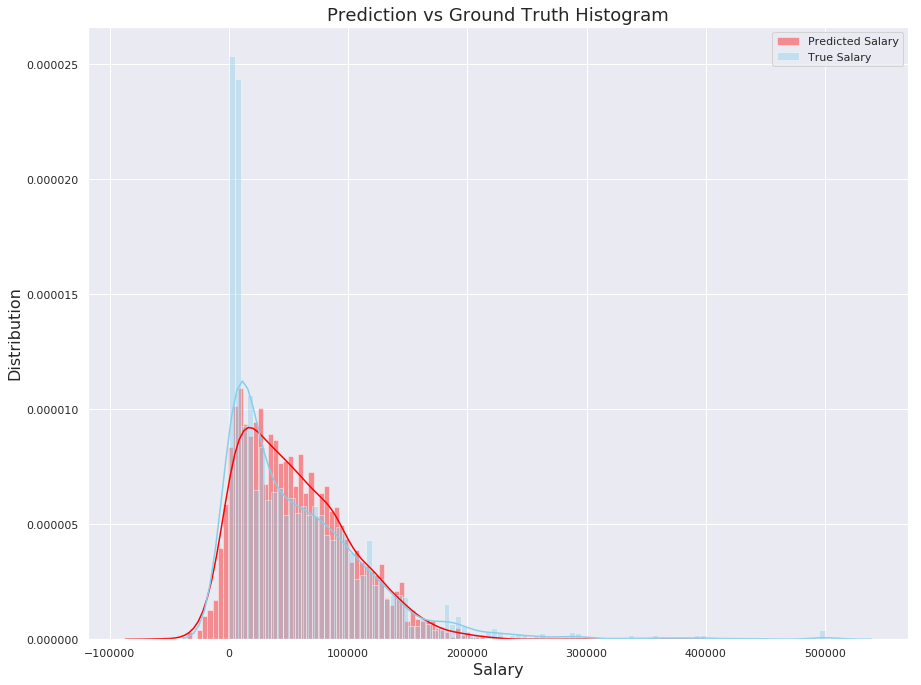

In [84]:
font_size=16
label_size=12
sns.distplot( plot_result["pred"], bins=100,  color="red",label='Predicted Salary')
ax=sns.distplot( plot_result["true"], bins=100, color="skyblue",label='True Salary')
plt.legend()
ax.axes.set_title('Prediction vs Ground Truth Histogram',fontsize=font_size+2);
ax.set_xlabel('Salary',fontsize=font_size);
ax.set_ylabel('Distribution',fontsize=font_size);


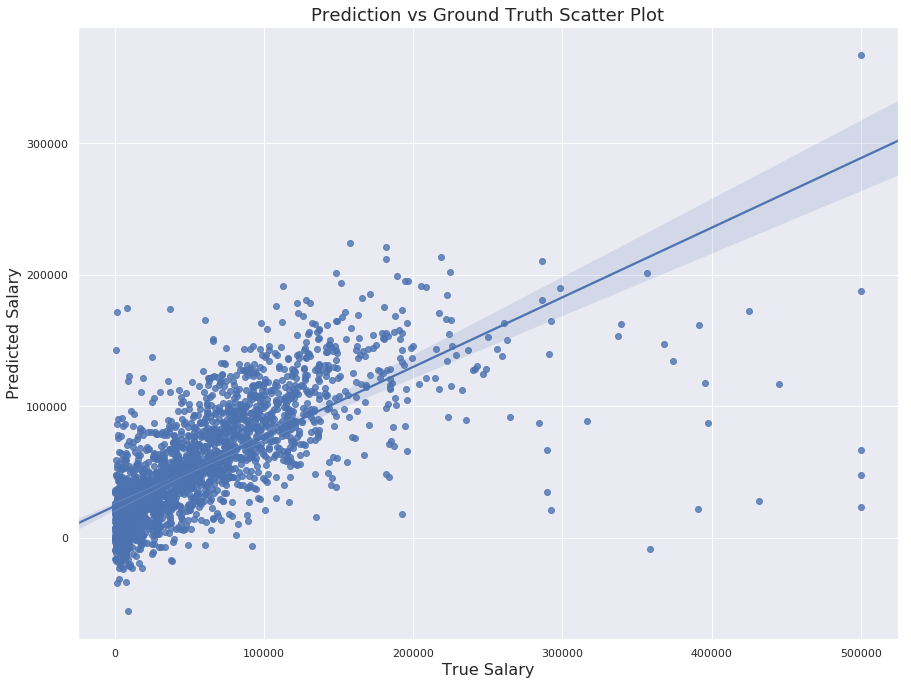

In [85]:
ax = sns.regplot(x="true", y="pred", data=plot_result)
font_size=16
label_size=12
ax.axes.set_title('Prediction vs Ground Truth Scatter Plot',fontsize=font_size+2);
ax.set_xlabel('True Salary',fontsize=font_size);
ax.set_ylabel('Predicted Salary',fontsize=font_size);

### 6.2 Result Discussion

**Model Performance and Sources of Error:**  
Use your optimal model to make predictions on the test set. How does your model
perform on the test set vs. the training set? The overall fit of the model, how to increase
the accuracy (test, training)? Is it overfitting or underfitting? Why?
Insufficient discussion will lead to the deduction on marks.

The model generally overpredicts the the salary on the data points. This is as shown in the histogram distribution. In that graph, it is shown that the predicted value (red) is generally higher than the true value (blue). This means that the model is generally over predicting. The exception being at the head and tail of the histogram distribution, where the true value have a lot more datapoints in those bins. Specifically, the true value have some data points that are very high.

A furtherlook at the scatter plot with a linear line fitted between the predicted salary and the true salary. This plot further shows that the predicted salary values are predicted higher. If the prediction values are about equal, then the linear line would have a slope near 1, however, it has a slow less than 1 as seen in the plot. Furthermore, the margins shown on the line shows that there is a lot more variance in prediction as the model tries to predict higher salary values. Starting from 200000, the margins on the regression line increases, showing that the plot is not doing well when trying to predict the really high true salaries. 

Generally, the model is overpredicting the low salaries, and under predicting the high salaries. Potential causes and solutions are listed below:
1. **Cause:** Due to the very high true salary values that the model saw, the model tries to compensate by over predicting the most of the data that it sees. The very high salary values are throwing the model off.   
  **Solution 1:** Perform outlier detection on the dataset and remove those. This would weed out the outliers that is potentially costing the model performance.  
  **Solution 2:** Use Ensemble Method such as gradient boosting to fit a model on the residuals of the prediction. Given that the model has an obvious prediction triend for majority of the model, an ensemble of weak linear learners applied to the residual might improve. Note that gradient boosted decision tree was tried in step 4, but was later removed due to it being very time consuming to train.  
  
  
2. **Cause:** There isn't enough data on the salaries that have a very high salary number. Thus causing the model not having enough data to properly fit thost points.  
  **Solution:** Get more data for the salaries that are on the high end of the spectrum. This could improve the mode.
  
**Model Fit:**  
The cross validation of the model after turning is the following:
```
Training Mean Absolute Error: 15170.94 (+/- 671.73)
Training Explained Variance: 0.67 (+/- 0.02)
Training R2 Score: 0.66 (+/- 0.02)

Test Mean Absolute Error: 24265.32 (+/- 7290.02)
Test Explained Variance: 0.51 (+/- 0.14)
Test R2 Score: 0.50 (+/- 0.14)
```

For this model, the C parameter, i.e, the penalty term is very high, meaning that the model is very unlikely to overfit. Typically, seeing the perform metrics above would suggest that the model is slightly overfitted due to the training metrics are shown to be perform about 15% better than the testing metrics. However, this would be attributed to the model cannot predict the test scores very well due to the outlier salary data points as mentioned above.


## Bonus: Neural Network

In [86]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

y=salary_onehot[['Q9','Q9_entry_counts']]
y=y.drop(columns=['Q9_entry_counts'])
X = salary_onehot.drop(columns=['Q9','Q9_entry_counts'])

entry_count_col=X.columns.values.tolist()
for i in entry_count_col:
    if i[:-13]!='entry_counts':
        entry_count_col.remove(i)

scaler = MinMaxScaler(feature_range=(0,1), copy=False)
X[entry_count_col]=scaler.fit_transform(X[entry_count_col])

# Feature Selection on the scaled dataset
print('Dataframe Shape Before Feature Selection: '+ str(X.shape))

clf = ExtraTreesRegressor(n_estimators=50, n_jobs=-1, random_state=42)
clf = clf.fit(X, y)

model = SelectFromModel(clf, prefit=True)
X= model.transform(X)
print('Dataframe Shape After Feature Selection: '+ str(X.shape))             

mlp = MLPRegressor(hidden_layer_sizes=(100,50,20,10),activation='relu', solver='lbfgs',max_iter=100, early_stopping =True,alpha=0.2)
mlp_scores = cross_validate(mlp, X, y, scoring=scoring,cv=10, return_train_score=True, verbose=2)

regression_report (cv=mlp_scores,print_cv=True)

Dataframe Shape Before Feature Selection: (7910, 352)
Dataframe Shape After Feature Selection: (7910, 68)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   3.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ................................................. , total=   3.1s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   2.8s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   3.1s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.0s finished


#### Neural Net Grid Search

In [ ]:
mlp_gridsearch = MLPRegressor()
#Parameters to test
parameters = {'alpha': [1e-4,1e-3,1e-2,1e-1], 
              'hidden_layer_sizes': [(20,10),(80,10)],
              'activation':['identity', 'logistic', 'tanh', 'relu'],
              'solver':['lbfgs', 'sgd', 'adam'],
              'learning_rate':['constant', 'invscaling', 'adaptive']}

# Compare parameters by score of model 
acc_scorer_lm = make_scorer(r2_score)

#define gridsearch setup
grid_obj_lm = GridSearchCV(mlp_gridsearch, parameters, scoring=acc_scorer_lm, n_jobs=-1, cv=3, verbose=2)
# Run the grid search
grid_obj_lm = grid_obj_lm.fit(X, y)

#using best estimator to run a prediction
mlp_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination
print('Best Estimator: ')
print(reg_gridsearch)
print("")

mlp_scores = cross_validate(mlp_gridsearch, X, y, scoring=scoring,cv=10, return_train_score=False)
regression_report (cv=mlp_scores,print_cv=True)